# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
#calling it a second time may prevent some graphics errors
import matplotlib.pyplot as plt

In [2]:
import os
import glob
import git
import sys


In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
# import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [4]:
import umap
from sklearn.preprocessing import StandardScaler
import sklearn.cluster as cluster


In [5]:
import cv2 
import os 

In [6]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [7]:
git_root

'/nancy/user/riwata/projects/reward_comp_ext'

In [8]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [9]:
import utilities.helper
import sleap.process_pose

In [10]:
# sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

# Functions

In [11]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

In [12]:
def rolling_average(arr, window_size):
    """
    Computes the rolling average using a specified window size.
    
    Parameters:
        arr (numpy.array): The input array to compute the rolling average for.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.array: The rolling average of the input array.
    """
    if window_size < 1:
       raise ValueError("Window size must be at least 1.")
    
    # Create a uniform window of given window size
    window = np.ones(window_size) / window_size

    # Use numpy's convolve function to compute the rolling average
    return np.convolve(arr, window, mode='valid')



In [13]:
def chunked_average(arr, chunk_size):
    """
    Computes the average for non-overlapping chunks of the input array.
    
    Parameters:
        arr (numpy.array): The input array.
        chunk_size (int): The size of each chunk.

    Returns:
        numpy.array: The averages of the non-overlapping chunks.
    """

    # Number of chunks
    num_chunks = len(arr) // chunk_size
    
    # Reshape the array into a 2D array of shape (num_chunks, chunk_size)
    reshaped_arr = arr[:num_chunks * chunk_size].reshape(num_chunks, chunk_size)
    
    # Compute the mean along the second axis (i.e., for each chunk)
    return reshaped_arr.mean(axis=1)

In [14]:
def sliding_window_average(arr, window_size, step=1):
    """
    Apply a sliding window to a 1D numpy array, returning the average of windows of a specified size.

    :param arr: Input 1D numpy array.
    :param window_size: Size of the window.
    :param step: The step size or number of elements to slide the window by. Default is 1.
    :return: A 1D numpy array where each element is the average of a window from the input.
    """
    # Number of windows
    num_windows = ((arr.size - window_size) // step) + 1
    
    # Output array for averages
    averages = np.zeros(num_windows)
    
    for i in range(num_windows):
        # Calculate the start and end index for the window
        start = i * step
        end = start + window_size
        # Calculate the average of the window
        averages[i] = np.mean(arr[start:end])

    return averages

In [15]:
def calculate_all_window_indices(original_index, window_size, step, array_length):
    """
    Calculate all the start and stop indices for sliding windows based on an original start index.

    :param original_index: The original index from which the first window should start.
    :param window_size: The size of each sliding window.
    :param step: The step size or number of elements to slide the window by.
    :param array_length: The total number of elements in the array.
    :return: A list of tuples, each containing the start and stop indices for a sliding window.
    """

    # Initialize the list to hold the start and stop indices for all windows
    windows = []

    # Initialize the current start index with the original index
    current_start_index = original_index

    # Loop through the array until the end is reached
    while current_start_index + window_size <= original_index + array_length:
        # Calculate the stop index based on the window size
        stop_index = current_start_index + window_size

        # Add the start and stop indices to the list
        windows.append((current_start_index, stop_index))

        # Update the current start index by adding the step size
        current_start_index += step

    return windows

In [16]:
def calculate_angle(ax, ay, bx, by, cx, cy):
    """
    Calculate the smallest angle between the vectors BA and BC with all points given in Cartesian coordinates.

    Parameters:
        ax, ay (float): Coordinates of point A.
        bx, by (float): Coordinates of point B, the vertex of the angle.
        cx, cy (float): Coordinates of point C.

    Returns:
        float: The smallest angle between vectors BA and BC, in radians, within the range [0, pi].
    """
    # Calculate the angles of vectors BA and BC relative to the positive x-axis
    ang_ba = np.arctan2(ay - by, ax - bx)
    ang_bc = np.arctan2(cy - by, cx - bx)

    # Compute the difference of angles
    ang = ang_bc - ang_ba

    # Normalize the angle to the range [0, 2*pi)
    ang = (ang + 2 * np.pi) % (2 * np.pi)

    # Ensure the angle is within [0, pi]
    if ang > np.pi:
        ang = 2 * np.pi - ang

    return ang

# Example usage:
ax, ay = 0, 1  # Coordinates for point A
bx, by = 0, 0  # Coordinates for point B (origin)
cx, cy = -0.5, 0.5  # Coordinates for point C

angle = calculate_angle(ax, ay, bx, by, cx, cy)
print("Angle in radians:", angle)
print("Angle in degrees:", np.degrees(angle))

Angle in radians: 0.7853981633974483
Angle in degrees: 45.0


In [17]:
def calculate_time_series_angles(A, B, C):
    """
    Calculate the smallest angle between vectors BA and BC for arrays of 2D points over time.

    Parameters:
        A, B, C (np.array): Each is a 2D numpy array of shape (T, 2) where T is the number of time steps.
                            Each array holds the x and y coordinates of points A, B, and C over time.

    Returns:
        np.array: Array of smallest angles between vectors BA and BC, in radians, within the range [0, pi].
    """
    # Extract x and y coordinates
    ax, ay = A[:, 0], A[:, 1]
    bx, by = B[:, 0], B[:, 1]
    cx, cy = C[:, 0], C[:, 1]
    
    # Calculate the angles of vectors BA and BC relative to the positive x-axis
    ang_ba = np.arctan2(ay - by, ax - bx)
    ang_bc = np.arctan2(cy - by, cx - bx)
    
    # Compute the difference of angles
    ang = ang_bc - ang_ba
    
    # Normalize the angle to the range [0, 2*pi)
    ang = (ang + 2 * np.pi) % (2 * np.pi)
    
    # Ensure the angle is within [0, pi]
    ang[ang > np.pi] = 2 * np.pi - ang[ang > np.pi]
    
    return ang

In [18]:
# Concatenating and stacking arrays from all columns
def concat_arrays(row):
    return np.hstack(row)



## Inputs & Data

Explanation of each input and where it comes from.

In [19]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1

# LFP_SPECTRAL_DF = pd.read_pickle("./proc/rce_pilot_2_03_spectral_bands.pkl")
# LFP_SPECTRAL_DF["video_name"] = LFP_SPECTRAL_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync"))

# SLEAP_DIR = os.path.join(git_root, "proc/sleap") 
# SLEAP_DIR = "/scratch/back_up/reward_competition_extention/final_proc/id_corrected"
SLEAP_DIR = "./data"

OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
WINDOW_SIZE = 25
DISTANCE_THRESHOLD = 2

In [20]:
START_STOP_FRAME_DF = pd.read_excel("./data/rce_pilot_3_long_comp_per_subject_start_stop_video_frame.xlsx")


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [21]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_3"

In [22]:
FULL_LFP_TRACES_PKL = "{}_04_spectral_and_sleap.pkl".format(OUTPUT_PREFIX)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

# Getting the videos where the subject is in the recording

### Looking at when each subject was in each video

In [23]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset=["file_path"])

- Getting the name of the SLEAP and video files where each subject was in

In [24]:
START_STOP_FRAME_DF["sleap_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: os.path.basename(x))
START_STOP_FRAME_DF["video_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: ".".join(os.path.basename(x).split(".")[:2]))
START_STOP_FRAME_DF["start_frame"] = START_STOP_FRAME_DF["start_frame"].astype(int)
START_STOP_FRAME_DF["stop_frame"] = START_STOP_FRAME_DF["stop_frame"].astype(int)

In [25]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(columns=["file_path", "notes"], errors="ignore")

In [26]:
START_STOP_FRAME_DF["video_name"].unique()

array(['20240317_151922_long_comp_subj_3-1_and_3-3.1',
       '20240317_172017_long_comp_subj_4-2_and_4-3.1',
       '20240318_143819_long_comp_subj_3-3_and_3-4.1',
       '20240318_170933_long_comp_subj_4-3_and_4-4.1',
       '20240319_134914_long_comp_subj_3-1_and_3-4.1',
       '20240319_160457_long_comp_subj_4-2_and_4-4.1',
       '20240320_114629_long_comp_subj_5-3_and_5-4.1',
       '20240321_114851_long_comp_subj_5-2_and_5-3.1'], dtype=object)

In [27]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name
0,1,45736,3.1_3.3,3.1_3.3,1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1
1,1,58878,4.2_4.3,4.2_4.3,1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1
2,1,58752,3.3_3.4,3.3_3.4,1,20240318_143819_long_comp_subj_3-3_and_3-4.1.2...,20240318_143819_long_comp_subj_3-3_and_3-4.1
3,1,58364,4.3_4.4,4.3_4.4,1,20240318_170933_long_comp_subj_4-3_and_4-4.1.2...,20240318_170933_long_comp_subj_4-3_and_4-4.1
4,1,57677,3.1_3.4,3.1_3.4,1,20240319_134914_long_comp_subj_3-1_and_3-4.1.2...,20240319_134914_long_comp_subj_3-1_and_3-4.1


- Splitting each row into seperate row for each subject in the video

In [28]:
START_STOP_FRAME_DF["tracked_subject"] = START_STOP_FRAME_DF["tracked_subject"].apply(lambda x: str(x).split("_"))
START_STOP_FRAME_DF["current_subject"] = START_STOP_FRAME_DF["tracked_subject"]

In [29]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.explode("current_subject")

In [30]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject
0,1,45736,"[3.1, 3.3]",3.1_3.3,1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1
0,1,45736,"[3.1, 3.3]",3.1_3.3,1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.3
1,1,58878,"[4.2, 4.3]",4.2_4.3,1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.2
1,1,58878,"[4.2, 4.3]",4.2_4.3,1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.3
2,1,58752,"[3.3, 3.4]",3.3_3.4,1,20240318_143819_long_comp_subj_3-3_and_3-4.1.2...,20240318_143819_long_comp_subj_3-3_and_3-4.1,3.3


In [31]:
START_STOP_FRAME_DF.shape

(16, 8)

# Reading in the h5 files between recordings

In [32]:
START_STOP_FRAME_DF["sleap_glob"] = START_STOP_FRAME_DF["sleap_name"].apply(lambda x: glob.glob(os.path.join(SLEAP_DIR, "**", x)))


In [33]:
for name in START_STOP_FRAME_DF[START_STOP_FRAME_DF["sleap_glob"].apply(lambda x: len(x) == 0)]["sleap_name"]:
    print(name)

In [34]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF['sleap_glob'].apply(lambda x: len(x) >= 1)]
START_STOP_FRAME_DF = START_STOP_FRAME_DF.reset_index(drop=True)




In [35]:
START_STOP_FRAME_DF["sleap_path"] = START_STOP_FRAME_DF["sleap_glob"].apply(lambda x: x[0])

In [36]:
START_STOP_FRAME_DF["all_sleap_data"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: sleap.process_pose.extract_sleap_data(x))


In [37]:
START_STOP_FRAME_DF["body_parts"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [38]:
START_STOP_FRAME_DF["body_parts"].iloc[0]

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

In [39]:
START_STOP_FRAME_DF["locations"] = START_STOP_FRAME_DF["all_sleap_data"].apply(lambda x: x["locations"])

In [40]:
START_STOP_FRAME_DF["track_names"] = START_STOP_FRAME_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [41]:
START_STOP_FRAME_DF["locations"].iloc[0].shape

(45736, 6, 2, 2)

In [42]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,all_sleap_data,body_parts,locations,track_names
0,1,45736,"[3.1, 3.3]",3.1_3.3,1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,[./data/20240317_151922_long_comp_subj_3-1_and...,./data/20240317_151922_long_comp_subj_3-1_and_...,{'locations': [[[[637.70965576 552.13781738] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[637.70965576 552.13781738], [576.05584717 ...","[3.1, 3.3]"
1,1,45736,"[3.1, 3.3]",3.1_3.3,1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.3,[./data/20240317_151922_long_comp_subj_3-1_and...,./data/20240317_151922_long_comp_subj_3-1_and_...,{'locations': [[[[637.70965576 552.13781738] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[637.70965576 552.13781738], [576.05584717 ...","[3.1, 3.3]"
2,1,58878,"[4.2, 4.3]",4.2_4.3,1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.2,[./data/20240317_172017_long_comp_subj_4-2_and...,./data/20240317_172017_long_comp_subj_4-2_and_...,{'locations': [[[[674.97369385 637.52838135] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[674.97369385 637.52838135], [573.16546631 ...","[4.2, 4.3]"
3,1,58878,"[4.2, 4.3]",4.2_4.3,1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.3,[./data/20240317_172017_long_comp_subj_4-2_and...,./data/20240317_172017_long_comp_subj_4-2_and_...,{'locations': [[[[674.97369385 637.52838135] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[674.97369385 637.52838135], [573.16546631 ...","[4.2, 4.3]"
4,1,58752,"[3.3, 3.4]",3.3_3.4,1,20240318_143819_long_comp_subj_3-3_and_3-4.1.2...,20240318_143819_long_comp_subj_3-3_and_3-4.1,3.3,[./data/20240318_143819_long_comp_subj_3-3_and...,./data/20240318_143819_long_comp_subj_3-3_and_...,{'locations': [[[[813.31793213 445.26257324] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[813.31793213 445.26257324], [162.67417908 ...","[3.3, 3.4]"


In [43]:
# Getting the indexes of each subject from the track list
START_STOP_FRAME_DF["subject_to_index"] = START_STOP_FRAME_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["tracked_subject"] if k in x["track_names"]}, axis=1)

In [44]:
START_STOP_FRAME_DF["subject_to_index"].head()

0    {'3.1': 0, '3.3': 1}
1    {'3.1': 0, '3.3': 1}
2    {'4.2': 0, '4.3': 1}
3    {'4.2': 0, '4.3': 1}
4    {'3.3': 0, '3.4': 1}
Name: subject_to_index, dtype: object

In [45]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [46]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [47]:
START_STOP_FRAME_DF["subject_to_tracks"].head()

0    {'3.1': [[[637.70965576 576.05584717], [626.12...
1    {'3.1': [[[637.70965576 576.05584717], [626.12...
2    {'4.2': [[[674.97369385 573.16546631], [645.37...
3    {'4.2': [[[674.97369385 573.16546631], [645.37...
4    {'3.3': [[[813.31793213 162.67417908], [847.95...
Name: subject_to_tracks, dtype: object

In [48]:
START_STOP_FRAME_DF["subject_to_tracks"].apply(lambda x: x.keys()).head()

0    (3.1, 3.3)
1    (3.1, 3.3)
2    (4.2, 4.3)
3    (4.2, 4.3)
4    (3.3, 3.4)
Name: subject_to_tracks, dtype: object

In [49]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,all_sleap_data,body_parts,locations,track_names,subject_to_index,subject_to_tracks
0,1,45736,"[3.1, 3.3]",3.1_3.3,1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,[./data/20240317_151922_long_comp_subj_3-1_and...,./data/20240317_151922_long_comp_subj_3-1_and_...,{'locations': [[[[637.70965576 552.13781738] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[637.70965576 552.13781738], [576.05584717 ...","[3.1, 3.3]","{'3.1': 0, '3.3': 1}","{'3.1': [[[637.70965576 576.05584717], [626.12..."
1,1,45736,"[3.1, 3.3]",3.1_3.3,1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.3,[./data/20240317_151922_long_comp_subj_3-1_and...,./data/20240317_151922_long_comp_subj_3-1_and_...,{'locations': [[[[637.70965576 552.13781738] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[637.70965576 552.13781738], [576.05584717 ...","[3.1, 3.3]","{'3.1': 0, '3.3': 1}","{'3.1': [[[637.70965576 576.05584717], [626.12..."
2,1,58878,"[4.2, 4.3]",4.2_4.3,1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.2,[./data/20240317_172017_long_comp_subj_4-2_and...,./data/20240317_172017_long_comp_subj_4-2_and_...,{'locations': [[[[674.97369385 637.52838135] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[674.97369385 637.52838135], [573.16546631 ...","[4.2, 4.3]","{'4.2': 0, '4.3': 1}","{'4.2': [[[674.97369385 573.16546631], [645.37..."
3,1,58878,"[4.2, 4.3]",4.2_4.3,1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.3,[./data/20240317_172017_long_comp_subj_4-2_and...,./data/20240317_172017_long_comp_subj_4-2_and_...,{'locations': [[[[674.97369385 637.52838135] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[674.97369385 637.52838135], [573.16546631 ...","[4.2, 4.3]","{'4.2': 0, '4.3': 1}","{'4.2': [[[674.97369385 573.16546631], [645.37..."
4,1,58752,"[3.3, 3.4]",3.3_3.4,1,20240318_143819_long_comp_subj_3-3_and_3-4.1.2...,20240318_143819_long_comp_subj_3-3_and_3-4.1,3.3,[./data/20240318_143819_long_comp_subj_3-3_and...,./data/20240318_143819_long_comp_subj_3-3_and_...,{'locations': [[[[813.31793213 445.26257324] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[813.31793213 445.26257324], [162.67417908 ...","[3.3, 3.4]","{'3.3': 0, '3.4': 1}","{'3.3': [[[813.31793213 162.67417908], [847.95..."


## Getting the coordinates of the corners

In [50]:
START_STOP_FRAME_DF["sleap_path"].iloc[0]

'./data/20240317_151922_long_comp_subj_3-1_and_3-3/20240317_151922_long_comp_subj_3-1_and_3-3.1.2_subj.id_corrected.h5'

In [51]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
START_STOP_FRAME_DF["corner_path"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: x.replace("id_corrected.h5", "corner.h5").replace(".fixed", "").replace(".round_1", "").replace(".1_subj", "").replace(".2_subj", ""))


In [52]:
START_STOP_FRAME_DF["corner_path"].iloc[0]

'./data/20240317_151922_long_comp_subj_3-1_and_3-3/20240317_151922_long_comp_subj_3-1_and_3-3.1.corner.h5'

In [53]:
# Getting the indexes of each corner location
START_STOP_FRAME_DF["corner_parts"] = START_STOP_FRAME_DF["corner_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [54]:
START_STOP_FRAME_DF["corner_parts"]

0     [box_bottom_right, reward_port, box_top_left, ...
1     [box_bottom_right, reward_port, box_top_left, ...
2     [box_bottom_right, box_bottom_left, box_top_ri...
3     [box_bottom_right, box_bottom_left, box_top_ri...
4     [box_bottom_right, box_bottom_left, box_top_ri...
5     [box_bottom_right, box_bottom_left, box_top_ri...
6     [box_bottom_right, box_bottom_left, box_top_ri...
7     [box_bottom_right, box_bottom_left, box_top_ri...
8     [box_bottom_right, box_bottom_left, box_top_ri...
9     [box_bottom_right, box_bottom_left, box_top_ri...
10    [box_bottom_right, box_bottom_left, box_top_ri...
11    [box_bottom_right, box_bottom_left, box_top_ri...
12    [box_bottom_right, box_bottom_left, box_top_ri...
13    [box_bottom_right, box_bottom_left, box_top_ri...
14    [box_top_left, box_bottom_left, box_top_right,...
15    [box_top_left, box_bottom_left, box_top_right,...
Name: corner_parts, dtype: object

In [55]:
# TODO: Remove this once corner files are fixed
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF["corner_parts"].apply(lambda x: "reward_port" in x)]

In [56]:
# Getting the coordinates of all the corners
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF["corner_path"].apply(lambda x: sleap.process_pose.get_sleap_tracks_from_h5(x))

In [57]:
# Parsing out each corner and creating a dictionary of name to coordinates
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [58]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_bottom_right': [[[808.46932083], [574.68...
1     {'box_bottom_right': [[[808.46932083], [574.68...
2     {'box_bottom_right': [[[808.86323958], [548.72...
3     {'box_bottom_right': [[[808.86323958], [548.72...
4     {'box_bottom_right': [[[804.09395591], [564.04...
5     {'box_bottom_right': [[[804.09395591], [564.04...
6     {'box_bottom_right': [[[806.92696893], [565.21...
7     {'box_bottom_right': [[[806.92696893], [565.21...
8     {'box_bottom_right': [[[807.50806016], [537.52...
9     {'box_bottom_right': [[[807.50806016], [537.52...
10    {'box_bottom_right': [[[808.22617852], [533.82...
11    {'box_bottom_right': [[[808.22617852], [533.82...
12    {'box_bottom_right': [[[804.98611813], [534.91...
13    {'box_bottom_right': [[[804.98611813], [534.91...
14    {'box_top_left': [[[476.6747334], [160.0822548...
15    {'box_top_left': [[[476.6747334], [160.0822548...
Name: corner_to_coordinate, dtype: object

In [59]:
# Filtering out all the Nans because there's only one labeled frame
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF.apply(lambda x: {k: v[~np.isnan(v)][:2] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [60]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_bottom_right': [808.4693208328993, 574.6...
1     {'box_bottom_right': [808.4693208328993, 574.6...
2     {'box_bottom_right': [808.8632395810237, 548.7...
3     {'box_bottom_right': [808.8632395810237, 548.7...
4     {'box_bottom_right': [804.0939559098848, 564.0...
5     {'box_bottom_right': [804.0939559098848, 564.0...
6     {'box_bottom_right': [806.9269689330013, 565.2...
7     {'box_bottom_right': [806.9269689330013, 565.2...
8     {'box_bottom_right': [807.5080601608829, 537.5...
9     {'box_bottom_right': [807.5080601608829, 537.5...
10    {'box_bottom_right': [808.2261785227747, 533.8...
11    {'box_bottom_right': [808.2261785227747, 533.8...
12    {'box_bottom_right': [804.9861181310932, 534.9...
13    {'box_bottom_right': [804.9861181310932, 534.9...
14    {'box_top_left': [476.67473340012816, 160.0822...
15    {'box_top_left': [476.67473340012816, 160.0822...
Name: corner_to_coordinate, dtype: object

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [61]:
# Using the x-coordinates for the width
START_STOP_FRAME_DF["bottom_width"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
START_STOP_FRAME_DF["top_width"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [62]:
# Using the y-coordinates for the height
START_STOP_FRAME_DF["right_height"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
START_STOP_FRAME_DF["left_height"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [63]:
# averaging the width and height by adding both sides and then getting the mean
START_STOP_FRAME_DF["average_height"] = START_STOP_FRAME_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
START_STOP_FRAME_DF["average_width"] = START_STOP_FRAME_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [64]:
START_STOP_FRAME_DF["width_ratio"] = MED_PC_WIDTH / START_STOP_FRAME_DF["average_width"]
START_STOP_FRAME_DF["height_ratio"] = MED_PC_HEIGHT / START_STOP_FRAME_DF["average_height"]

In [65]:
START_STOP_FRAME_DF["height_ratio"]

0     0.061260
1     0.061260
2     0.060448
3     0.060448
4     0.060720
5     0.060720
6     0.061349
7     0.061349
8     0.060913
9     0.060913
10    0.061913
11    0.061913
12    0.059982
13    0.059982
14    0.061347
15    0.061347
Name: height_ratio, dtype: float64

In [66]:
START_STOP_FRAME_DF["width_ratio"]

0     0.092458
1     0.092458
2     0.092656
3     0.092656
4     0.093842
5     0.093842
6     0.092889
7     0.092889
8     0.092910
9     0.092910
10    0.092961
11    0.092961
12    0.094583
13    0.094583
14    0.092821
15    0.092821
Name: width_ratio, dtype: float64

## Converting Pixels to cm

In [67]:
START_STOP_FRAME_DF["in_video_subjects"] = START_STOP_FRAME_DF["in_video_subjects"].apply(lambda x: x.split("_"))

In [68]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k: v for k, v in x["subject_to_tracks"].items() if k in x["in_video_subjects"]}, axis=1)

- Converting the X-dimension

In [69]:
START_STOP_FRAME_DF["subject_to_tracks"].head()

0    {'3.1': [[[637.70965576 576.05584717], [626.12...
1    {'3.1': [[[637.70965576 576.05584717], [626.12...
2    {'4.2': [[[674.97369385 573.16546631], [645.37...
3    {'4.2': [[[674.97369385 573.16546631], [645.37...
4    {'3.3': [[[813.31793213 162.67417908], [847.95...
Name: subject_to_tracks, dtype: object

In [70]:
START_STOP_FRAME_DF["rescaled_locations"] = START_STOP_FRAME_DF.apply(lambda x: {key: sleap.process_pose.fill_missing(sleap.process_pose.rescale_dimension_in_array(value, dimension=0, ratio=x["width_ratio"])) for key, value in x["subject_to_tracks"].items()}, axis=1)

- Converting the Y-dimension

In [71]:
START_STOP_FRAME_DF["rescaled_locations"] = START_STOP_FRAME_DF.apply(lambda x: {key: sleap.process_pose.rescale_dimension_in_array(value, dimension=1, ratio=x["height_ratio"]) for key, value in x["rescaled_locations"].items()}, axis=1)

In [72]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_bottom_right': [808.4693208328993, 574.6...
1     {'box_bottom_right': [808.4693208328993, 574.6...
2     {'box_bottom_right': [808.8632395810237, 548.7...
3     {'box_bottom_right': [808.8632395810237, 548.7...
4     {'box_bottom_right': [804.0939559098848, 564.0...
5     {'box_bottom_right': [804.0939559098848, 564.0...
6     {'box_bottom_right': [806.9269689330013, 565.2...
7     {'box_bottom_right': [806.9269689330013, 565.2...
8     {'box_bottom_right': [807.5080601608829, 537.5...
9     {'box_bottom_right': [807.5080601608829, 537.5...
10    {'box_bottom_right': [808.2261785227747, 533.8...
11    {'box_bottom_right': [808.2261785227747, 533.8...
12    {'box_bottom_right': [804.9861181310932, 534.9...
13    {'box_bottom_right': [804.9861181310932, 534.9...
14    {'box_top_left': [476.67473340012816, 160.0822...
15    {'box_top_left': [476.67473340012816, 160.0822...
Name: corner_to_coordinate, dtype: object

In [73]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,corner_to_coordinate,bottom_width,top_width,right_height,left_height,average_height,average_width,width_ratio,height_ratio,rescaled_locations
0,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,[./data/20240317_151922_long_comp_subj_3-1_and...,./data/20240317_151922_long_comp_subj_3-1_and_...,...,"{'box_bottom_right': [808.4693208328993, 574.6...",321.427558,316.699600,388.209852,395.331909,391.770880,319.063579,0.092458,0.061260,"{'3.1': [[[58.96139859 35.28935157], [57.89003..."
1,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.3,[./data/20240317_151922_long_comp_subj_3-1_and...,./data/20240317_151922_long_comp_subj_3-1_and_...,...,"{'box_bottom_right': [808.4693208328993, 574.6...",321.427558,316.699600,388.209852,395.331909,391.770880,319.063579,0.092458,0.061260,"{'3.1': [[[58.96139859 35.28935157], [57.89003..."
2,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.2,[./data/20240317_172017_long_comp_subj_4-2_and...,./data/20240317_172017_long_comp_subj_4-2_and_...,...,"{'box_bottom_right': [808.8632395810237, 548.7...",319.349472,317.413475,397.543703,396.522381,397.033042,318.381473,0.092656,0.060448,"{'4.2': [[[62.54046054 34.64691786], [59.79832..."
3,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.3,[./data/20240317_172017_long_comp_subj_4-2_and...,./data/20240317_172017_long_comp_subj_4-2_and_...,...,"{'box_bottom_right': [808.8632395810237, 548.7...",319.349472,317.413475,397.543703,396.522381,397.033042,318.381473,0.092656,0.060448,"{'4.2': [[[62.54046054 34.64691786], [59.79832..."
4,1,58752,"[3.3, 3.4]","[3.3, 3.4]",1,20240318_143819_long_comp_subj_3-3_and_3-4.1.2...,20240318_143819_long_comp_subj_3-3_and_3-4.1,3.3,[./data/20240318_143819_long_comp_subj_3-3_and...,./data/20240318_143819_long_comp_subj_3-3_and_...,...,"{'box_bottom_right': [804.0939559098848, 564.0...",319.052405,309.666838,395.074978,395.434146,395.254562,314.359621,0.093842,0.060720,"{'3.3': [[[76.32303058 9.877635 ], [79.57301..."


In [74]:
# Normalize dictionary column
normalized = pd.json_normalize(START_STOP_FRAME_DF["corner_to_coordinate"])

In [75]:
normalized.head()

,box_bottom_right,reward_port,box_top_left,box_top_right,box_bottom_left
0,"[808.4693208328993, 574.6802250531325]","[653.4112199504154, 613.1971271451312]","[479.0257245955072, 188.42807300479728]","[795.7253246182136, 186.4703732037661]","[487.04176325378285, 583.7599819317704]"
1,"[808.4693208328993, 574.6802250531325]","[653.4112199504154, 613.1971271451312]","[479.0257245955072, 188.42807300479728]","[795.7253246182136, 186.4703732037661]","[487.04176325378285, 583.7599819317704]"
2,"[808.8632395810237, 548.7287602661135]","[649.6440274082779, 583.1693476844241]","[478.8534589901643, 162.4117263903811]","[796.266933891819, 151.18505760233734]","[489.5137678025899, 558.934107677138]"
3,"[808.8632395810237, 548.7287602661135]","[649.6440274082779, 583.1693476844241]","[478.8534589901643, 162.4117263903811]","[796.266933891819, 151.18505760233734]","[489.5137678025899, 558.934107677138]"
4,"[804.0939559098848, 564.0439743400614]","[645.3811744714114, 596.0361993487147]","[486.4215422287989, 169.3702355939721]","[796.088380295785, 168.96899603806548]","[485.0415511629777, 564.8043818466354]"


In [76]:


# Drop the original column and concat the normalized DataFrame
START_STOP_FRAME_DF = pd.concat([START_STOP_FRAME_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [77]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_bottom_right,reward_port,box_top_left,box_top_right,box_bottom_left
0,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,[./data/20240317_151922_long_comp_subj_3-1_and...,./data/20240317_151922_long_comp_subj_3-1_and_...,...,391.770880,319.063579,0.092458,0.061260,"{'3.1': [[[58.96139859 35.28935157], [57.89003...","[808.4693208328993, 574.6802250531325]","[653.4112199504154, 613.1971271451312]","[479.0257245955072, 188.42807300479728]","[795.7253246182136, 186.4703732037661]","[487.04176325378285, 583.7599819317704]"
1,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.3,[./data/20240317_151922_long_comp_subj_3-1_and...,./data/20240317_151922_long_comp_subj_3-1_and_...,...,391.770880,319.063579,0.092458,0.061260,"{'3.1': [[[58.96139859 35.28935157], [57.89003...","[808.4693208328993, 574.6802250531325]","[653.4112199504154, 613.1971271451312]","[479.0257245955072, 188.42807300479728]","[795.7253246182136, 186.4703732037661]","[487.04176325378285, 583.7599819317704]"
2,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.2,[./data/20240317_172017_long_comp_subj_4-2_and...,./data/20240317_172017_long_comp_subj_4-2_and_...,...,397.033042,318.381473,0.092656,0.060448,"{'4.2': [[[62.54046054 34.64691786], [59.79832...","[808.8632395810237, 548.7287602661135]","[649.6440274082779, 583.1693476844241]","[478.8534589901643, 162.4117263903811]","[796.266933891819, 151.18505760233734]","[489.5137678025899, 558.934107677138]"
3,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.3,[./data/20240317_172017_long_comp_subj_4-2_and...,./data/20240317_172017_long_comp_subj_4-2_and_...,...,397.033042,318.381473,0.092656,0.060448,"{'4.2': [[[62.54046054 34.64691786], [59.79832...","[808.8632395810237, 548.7287602661135]","[649.6440274082779, 583.1693476844241]","[478.8534589901643, 162.4117263903811]","[796.266933891819, 151.18505760233734]","[489.5137678025899, 558.934107677138]"
4,1,58752,"[3.3, 3.4]","[3.3, 3.4]",1,20240318_143819_long_comp_subj_3-3_and_3-4.1.2...,20240318_143819_long_comp_subj_3-3_and_3-4.1,3.3,[./data/20240318_143819_long_comp_subj_3-3_and...,./data/20240318_143819_long_comp_subj_3-3_and_...,...,395.254562,314.359621,0.093842,0.060720,"{'3.3': [[[76.32303058 9.877635 ], [79.57301...","[804.0939559098848, 564.0439743400614]","[645.3811744714114, 596.0361993487147]","[486.4215422287989, 169.3702355939721]","[796.088380295785, 168.96899603806548]","[485.0415511629777, 564.8043818466354]"


In [78]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset=["reward_port"])

- Converting the corner coordinates into cms

In [79]:
for corner in START_STOP_FRAME_DF["corner_parts"].iloc[0]:
    START_STOP_FRAME_DF[corner] = START_STOP_FRAME_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

## Looking over the tracks

In [80]:
FILE_INDEX = 0

In [81]:
START_STOP_FRAME_DF["sleap_path"].iloc[FILE_INDEX]

'./data/20240317_151922_long_comp_subj_3-1_and_3-3/20240317_151922_long_comp_subj_3-1_and_3-3.1.2_subj.id_corrected.h5'

In [82]:
START_STOP_FRAME_DF["rescaled_locations"].head()

0    {'3.1': [[[58.96139859 35.28935157], [57.89003...
1    {'3.1': [[[58.96139859 35.28935157], [57.89003...
2    {'4.2': [[[62.54046054 34.64691786], [59.79832...
3    {'4.2': [[[62.54046054 34.64691786], [59.79832...
4    {'3.3': [[[76.32303058  9.877635  ], [79.57301...
Name: rescaled_locations, dtype: object

In [83]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'sleap_glob', 'sleap_path', 'all_sleap_data', 'body_parts', 'locations',
       'track_names', 'subject_to_index', 'subject_to_tracks', 'corner_path',
       'corner_parts', 'bottom_width', 'top_width', 'right_height',
       'left_height', 'average_height', 'average_width', 'width_ratio',
       'height_ratio', 'rescaled_locations', 'box_bottom_right', 'reward_port',
       'box_top_left', 'box_top_right', 'box_bottom_left'],
      dtype='object')

In [84]:
with h5py.File(START_STOP_FRAME_DF["sleap_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    current_subject = START_STOP_FRAME_DF["current_subject"].iloc[FILE_INDEX]
    locations = START_STOP_FRAME_DF["rescaled_locations"].iloc[FILE_INDEX][current_subject]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(45736, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [85]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

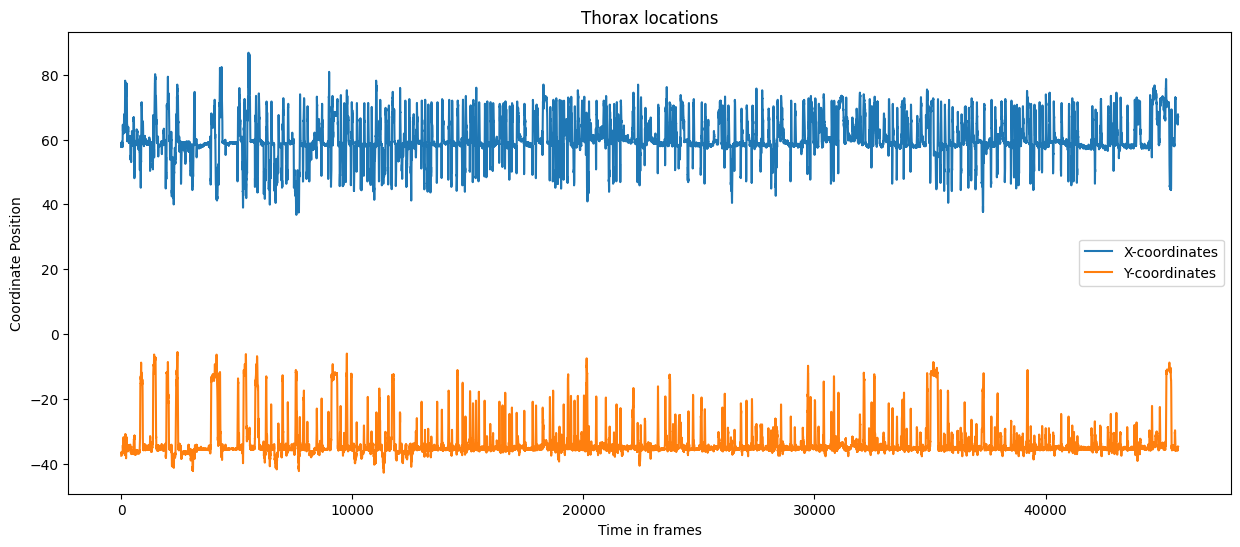

In [86]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

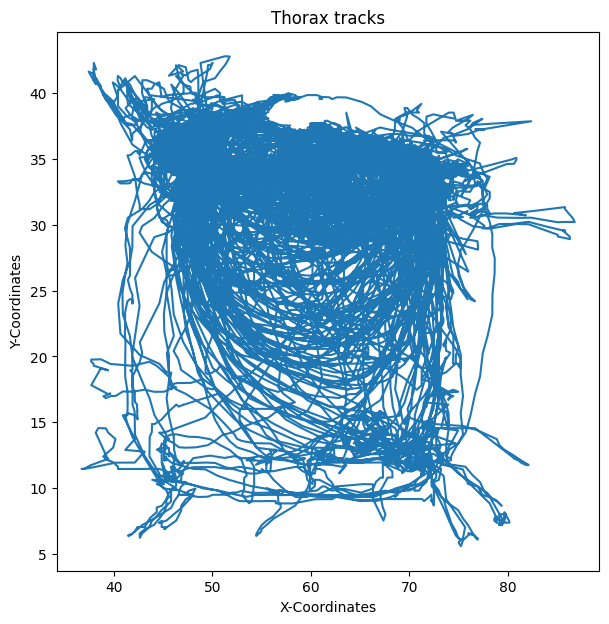

In [87]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


## Creating an individual column for each pose tracking

In [88]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset="current_subject")

In [89]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_bottom_right,reward_port,box_top_left,box_top_right,box_bottom_left
0,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,[./data/20240317_151922_long_comp_subj_3-1_and...,./data/20240317_151922_long_comp_subj_3-1_and_...,...,391.770880,319.063579,0.092458,0.061260,"{'3.1': [[[58.96139859 35.28935157], [57.89003...","[74.74950620876821, 35.20508055016655]","[60.41313477701829, 37.56463736381247]","[44.28978991796822, 11.54315948044538]","[73.57122102264293, 11.423230211638582]","[45.03093731344292, 35.761309141917415]"
1,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.3,[./data/20240317_151922_long_comp_subj_3-1_and...,./data/20240317_151922_long_comp_subj_3-1_and_...,...,391.770880,319.063579,0.092458,0.061260,"{'3.1': [[[58.96139859 35.28935157], [57.89003...","[74.74950620876821, 35.20508055016655]","[60.41313477701829, 37.56463736381247]","[44.28978991796822, 11.54315948044538]","[73.57122102264293, 11.423230211638582]","[45.03093731344292, 35.761309141917415]"
2,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.2,[./data/20240317_172017_long_comp_subj_4-2_and...,./data/20240317_172017_long_comp_subj_4-2_and_...,...,397.033042,318.381473,0.092656,0.060448,"{'4.2': [[[62.54046054 34.64691786], [59.79832...","[74.94614971567516, 33.169758821249765]","[60.1935112853622, 35.25163617313764]","[44.368715591445614, 9.817524037739831]","[73.77902458765409, 9.138890215293802]","[45.35645871188365, 33.78665543178387]"
3,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.3,[./data/20240317_172017_long_comp_subj_4-2_and...,./data/20240317_172017_long_comp_subj_4-2_and_...,...,397.033042,318.381473,0.092656,0.060448,"{'4.2': [[[62.54046054 34.64691786], [59.79832...","[74.94614971567516, 33.169758821249765]","[60.1935112853622, 35.25163617313764]","[44.368715591445614, 9.817524037739831]","[73.77902458765409, 9.138890215293802]","[45.35645871188365, 33.78665543178387]"
4,1,58752,"[3.3, 3.4]","[3.3, 3.4]",1,20240318_143819_long_comp_subj_3-3_and_3-4.1.2...,20240318_143819_long_comp_subj_3-3_and_3-4.1,3.3,[./data/20240318_143819_long_comp_subj_3-3_and...,./data/20240318_143819_long_comp_subj_3-3_and_...,...,395.254562,314.359621,0.093842,0.060720,"{'3.3': [[[76.32303058 9.877635 ], [79.57301...","[75.45743818234993, 34.248954157961684]","[60.56358180384908, 36.19153363328459]","[45.646560558659836, 10.284221972884431]","[74.70618240859957, 10.259858561906261]","[45.51706003228968, 34.29512637682901]"


In [90]:
START_STOP_FRAME_DF["agent"] = START_STOP_FRAME_DF.apply(lambda x: list((set(x["tracked_subject"]) - set([x["current_subject"]]))), axis=1)

In [91]:
START_STOP_FRAME_DF[START_STOP_FRAME_DF["agent"].apply(lambda x: len(x) != 1)]

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_width,width_ratio,height_ratio,rescaled_locations,box_bottom_right,reward_port,box_top_left,box_top_right,box_bottom_left,agent


In [92]:
START_STOP_FRAME_DF["agent"] = START_STOP_FRAME_DF["agent"].apply(lambda x: x[0] if len(x) == 1 else None)

In [93]:
START_STOP_FRAME_DF["subject_locations"] = START_STOP_FRAME_DF.apply(lambda x: x["rescaled_locations"][x["current_subject"]] , axis=1)

In [94]:
START_STOP_FRAME_DF["agent_locations"] = START_STOP_FRAME_DF.apply(lambda x: x["rescaled_locations"].get(x["agent"], np.nan) if x["agent"] else np.nan, axis=1)

## Getting all the timestamps

In [95]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'sleap_glob', 'sleap_path', 'all_sleap_data', 'body_parts', 'locations',
       'track_names', 'subject_to_index', 'subject_to_tracks', 'corner_path',
       'corner_parts', 'bottom_width', 'top_width', 'right_height',
       'left_height', 'average_height', 'average_width', 'width_ratio',
       'height_ratio', 'rescaled_locations', 'box_bottom_right', 'reward_port',
       'box_top_left', 'box_top_right', 'box_bottom_left', 'agent',
       'subject_locations', 'agent_locations'],
      dtype='object')

In [96]:
START_STOP_FRAME_DF["frame_index"] = START_STOP_FRAME_DF["subject_locations"].apply(lambda x: np.arange(0, x.shape[0]) + 1)

## Removing unnecessary columns

In [97]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(["sleap_glob", "subject_to_index", "subject_to_tracks", "corner_parts", "corner_to_coordinate", "bottom_width", "top_width", "right_height", "left_height", "average_height", "average_width", "width_ratio", "height_ratio", 'locations', 'track_names', 'sleap_path', 'corner_path', 'all_sleap_data', 'rescaled_locations'], errors="ignore", axis=1)

In [98]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'body_parts', 'box_bottom_right', 'reward_port', 'box_top_left',
       'box_top_right', 'box_bottom_left', 'agent', 'subject_locations',
       'agent_locations', 'frame_index'],
      dtype='object')

In [99]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,body_parts,box_bottom_right,reward_port,box_top_left,box_top_right,box_bottom_left,agent,subject_locations,agent_locations,frame_index
0,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.74950620876821, 35.20508055016655]","[60.41313477701829, 37.56463736381247]","[44.28978991796822, 11.54315948044538]","[73.57122102264293, 11.423230211638582]","[45.03093731344292, 35.761309141917415]",3.3,"[[[58.961398589179765, 35.28935156776581], [57...","[[[51.049592291310574, 19.27532173433335], [54...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.74950620876821, 35.20508055016655]","[60.41313477701829, 37.56463736381247]","[44.28978991796822, 11.54315948044538]","[73.57122102264293, 11.423230211638582]","[45.03093731344292, 35.761309141917415]",3.1,"[[[51.049592291310574, 19.27532173433335], [54...","[[[58.961398589179765, 35.28935156776581], [57...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.2,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.94614971567516, 33.169758821249765]","[60.1935112853622, 35.25163617313764]","[44.368715591445614, 9.817524037739831]","[73.77902458765409, 9.138890215293802]","[45.35645871188365, 33.78665543178387]",4.3,"[[[62.54046053502408, 34.646917855927946], [59...","[[[59.070922225644495, 9.032051361034663], [61...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.94614971567516, 33.169758821249765]","[60.1935112853622, 35.25163617313764]","[44.368715591445614, 9.817524037739831]","[73.77902458765409, 9.138890215293802]","[45.35645871188365, 33.78665543178387]",4.2,"[[[59.070922225644495, 9.032051361034663], [61...","[[[62.54046053502408, 34.646917855927946], [59...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,1,58752,"[3.3, 3.4]","[3.3, 3.4]",1,20240318_143819_long_comp_subj_3-3_and_3-4.1.2...,20240318_143819_long_comp_subj_3-3_and_3-4.1,3.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[75.45743818234993, 34.248954157961684]","[60.56358180384908, 36.19153363328459]","[45.646560558659836, 10.284221972884431]","[74.70618240859957, 10.259858561906261]","[45.51706003228968, 34.29512637682901]",3.4,"[[[76.32303058013719, 9.877634998966064], [79....","[[[41.7841383440293, 12.629758340372002], [42....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


# Calculate relavant features

## Features to calculate

1. velocity of the mice
2. distance between thoraxes
3. distances to port of mice
4. angles of orientation of mice to port




Original features to calculate
1. distance between thoraxes
2. velocity of mouse 1 + velocity of mouse 2
3. | velocity of mouse 1 - velocity of mouse 2 |
4. sum of angles of orientation of mice to port
5. | difference of angles of orientation of mice to port |
6. sum of distances to port of mice
7. | differences of distances to port of mice |

In [100]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'body_parts', 'box_bottom_right', 'reward_port', 'box_top_left',
       'box_top_right', 'box_bottom_left', 'agent', 'subject_locations',
       'agent_locations', 'frame_index'],
      dtype='object')

# Getting relavent body parts

In [101]:
START_STOP_FRAME_DF["body_parts"].apply(lambda x: x.index("thorax"))

0     4
1     4
2     4
3     4
4     4
5     4
6     4
7     4
8     4
9     4
10    4
11    4
12    4
13    4
14    4
15    4
Name: body_parts, dtype: int64

In [102]:
START_STOP_FRAME_DF["subject_thorax"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_locations"][:,x["body_parts"].index("thorax"),:], axis=1)
START_STOP_FRAME_DF["subject_nose"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_locations"][:,x["body_parts"].index("nose"),:], axis=1)


In [103]:
START_STOP_FRAME_DF["agent_thorax"] = START_STOP_FRAME_DF.apply(lambda x: x["agent_locations"][:,x["body_parts"].index("thorax"),:], axis=1)
START_STOP_FRAME_DF["agent_nose"] = START_STOP_FRAME_DF.apply(lambda x: x["agent_locations"][:,x["body_parts"].index("nose"),:], axis=1)


In [104]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,body_parts,box_bottom_right,...,box_top_right,box_bottom_left,agent,subject_locations,agent_locations,frame_index,subject_thorax,subject_nose,agent_thorax,agent_nose
0,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.74950620876821, 35.20508055016655]",...,"[73.57122102264293, 11.423230211638582]","[45.03093731344292, 35.761309141917415]",3.3,"[[[58.961398589179765, 35.28935156776581], [57...","[[[51.049592291310574, 19.27532173433335], [54...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[53.26825846282421, 35.44272664905175], [53.4...","[[60.66382553531819, 37.07189755148739], [61.1...","[[47.860821872785834, 22.07562467504836], [48....","[[55.48572827758468, 18.281517014558784], [56...."
1,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.74950620876821, 35.20508055016655]",...,"[73.57122102264293, 11.423230211638582]","[45.03093731344292, 35.761309141917415]",3.1,"[[[51.049592291310574, 19.27532173433335], [54...","[[[58.961398589179765, 35.28935156776581], [57...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[47.860821872785834, 22.07562467504836], [48....","[[55.48572827758468, 18.281517014558784], [56....","[[53.26825846282421, 35.44272664905175], [53.4...","[[60.66382553531819, 37.07189755148739], [61.1..."
2,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.2,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.94614971567516, 33.169758821249765]",...,"[73.77902458765409, 9.138890215293802]","[45.35645871188365, 33.78665543178387]",4.3,"[[[62.54046053502408, 34.646917855927946], [59...","[[[59.070922225644495, 9.032051361034663], [61...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[64.49947294329253, 32.24757065689345], [64.7...","[[59.79077179846604, 35.4790643362153], [59.99...","[[64.77850457174938, 9.353703539738483], [64.7...","[[57.0904027788065, 6.435686622212122], [56.83..."
3,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.94614971567516, 33.169758821249765]",...,"[73.77902458765409, 9.138890215293802]","[45.35645871188365, 33.78665543178387]",4.2,"[[[59.070922225644495, 9.032051361034663], [61...","[[[62.54046053502408, 34.646917855927946], [59...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[64.77850457174938, 9.353703539738483], [64.7...","[[57.0904027788065, 6.435686622212122], [56.83...","[[64.49947294329253, 32.24757065689345], [64.7...","[[59.79077179846604, 35.4790643362153], [59.99..."
4,1,58752,"[3.3, 3.4]","[3.3, 3.4]",1,20240318_143819_long_comp_subj_3-3_and_3-4.1.2...,20240318_143819_long_comp_subj_3-3_and_3-4.1,3.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[75.45743818234993, 34.248954157961684]",...,"[74.70618240859957, 10.259858561906261]","[45.51706003228968, 34.29512637682901]",3.4,"[[[76.32303058013719, 9.877634998966064], [79....","[[[41.7841383440293, 12.629758340372002], [42....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[75.8183973154975, 12.154808851954154], [75.8...","[[73.54560309260204, 10.344030862207466], [73....","[[44.26328779373866, 11.814603049564292], [70....","[[38.5149504510824, 10.356194206154214], [61.8..."


# Calculate velocity

In [105]:
START_STOP_FRAME_DF["subject_thorax_velocity"] = START_STOP_FRAME_DF.apply(lambda x: compute_velocity(x["subject_thorax"], window_size=FRAME_RATE*3) * FRAME_RATE, axis=1)
START_STOP_FRAME_DF["subject_thorax_velocity"] = START_STOP_FRAME_DF["subject_thorax_velocity"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [106]:
START_STOP_FRAME_DF["agent_locations"]

0     [[[51.049592291310574, 19.27532173433335], [54...
1     [[[58.961398589179765, 35.28935156776581], [57...
2     [[[59.070922225644495, 9.032051361034663], [61...
3     [[[62.54046053502408, 34.646917855927946], [59...
4     [[[41.7841383440293, 12.629758340372002], [42....
5     [[[76.32303058013719, 9.877634998966064], [79....
6     [[[71.872443898319, 33.84343717223429], [68.36...
7     [[[62.19518782084268, 36.15736706482171], [59....
8     [[[62.72088230858486, 33.459394206438375], [59...
9     [[[46.29841735720912, 18.536476588268414], [42...
10    [[[56.51021922764555, 34.19234080897241], [55....
11    [[[60.48739305019625, 22.309462862236177], [56...
12    [[[55.76061956288035, 33.110147668728196], [52...
13    [[[62.53634118533857, 32.30462379914193], [60....
14    [[[74.51479650607835, 29.28110790187565], [71....
15    [[[62.39854718508237, 34.98730998211935], [59....
Name: agent_locations, dtype: object

In [107]:
START_STOP_FRAME_DF["agent_thorax_velocity"] = START_STOP_FRAME_DF.apply(lambda x: compute_velocity(x["agent_thorax"], window_size=FRAME_RATE*3) * FRAME_RATE if x["agent_locations"] is not np.nan else np.nan, axis=1)
START_STOP_FRAME_DF["agent_thorax_velocity"] = START_STOP_FRAME_DF["agent_thorax_velocity"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)


In [108]:
START_STOP_FRAME_DF["subject_thorax_velocity"].iloc[0].shape

(45736,)

## Calculate relavant distances

1. distance between thoraxes

In [109]:
START_STOP_FRAME_DF["subject_thorax_to_agent_thorax"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_thorax"] - x["agent_thorax"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_thorax_to_agent_thorax"] = START_STOP_FRAME_DF["subject_thorax_to_agent_thorax"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

2. distances to port of mice

In [110]:
START_STOP_FRAME_DF["subject_thorax_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_thorax"] - x["reward_port"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_thorax_to_reward_port"] = START_STOP_FRAME_DF["subject_thorax_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [111]:
START_STOP_FRAME_DF["agent_thorax_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["agent_thorax"] - x["reward_port"], axis=1) if x["agent_locations"] is not np.nan else np.nan,  axis=1)
START_STOP_FRAME_DF["agent_thorax_to_reward_port"] = START_STOP_FRAME_DF["agent_thorax_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

## Calculating orientation of the mouse

4. angles of orientation of mice to port

In [112]:
START_STOP_FRAME_DF["subject_to_reward_port_angle"] = START_STOP_FRAME_DF.apply(lambda x: calculate_time_series_angles(x["subject_thorax"], x["subject_nose"], np.tile(x["reward_port"], (x["subject_nose"].shape[0], 1))),  axis=1)
START_STOP_FRAME_DF["subject_to_reward_port_angle"] = START_STOP_FRAME_DF["subject_to_reward_port_angle"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [113]:
START_STOP_FRAME_DF["agent_to_reward_port_angle"] = START_STOP_FRAME_DF.apply(lambda x: calculate_time_series_angles(x["agent_thorax"], x["agent_nose"], np.tile(x["reward_port"], (x["agent_nose"].shape[0], 1))),  axis=1)
START_STOP_FRAME_DF["agent_to_reward_port_angle"] = START_STOP_FRAME_DF["agent_to_reward_port_angle"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [114]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,body_parts,box_bottom_right,...,subject_nose,agent_thorax,agent_nose,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_agent_thorax,subject_thorax_to_reward_port,agent_thorax_to_reward_port,subject_to_reward_port_angle,agent_to_reward_port_angle
0,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.74950620876821, 35.20508055016655]",...,"[[60.66382553531819, 37.07189755148739], [61.1...","[[47.860821872785834, 22.07562467504836], [48....","[[55.48572827758468, 18.281517014558784], [56....","[3.0358572, 2.855401, 2.6804976, 2.5111659, 2....","[12.367696, 11.99045, 11.647436, 11.337412, 11...","[14.419424, 15.0991535, 15.672449, 16.414988, ...","[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[19.936651, 20.158562, 20.458246, 20.803932, 2...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1..."
1,1,45736,"[3.1, 3.3]","[3.1, 3.3]",1,20240317_151922_long_comp_subj_3-1_and_3-3.1.2...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.74950620876821, 35.20508055016655]",...,"[[55.48572827758468, 18.281517014558784], [56....","[[53.26825846282421, 35.44272664905175], [53.4...","[[60.66382553531819, 37.07189755148739], [61.1...","[12.367696, 11.99045, 11.647436, 11.337412, 11...","[3.0358572, 2.855401, 2.6804976, 2.5111659, 2....","[14.419424, 15.0991535, 15.672449, 16.414988, ...","[19.936651, 20.158562, 20.458246, 20.803932, 2...","[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ..."
2,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.2,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.94614971567516, 33.169758821249765]",...,"[[59.79077179846604, 35.4790643362153], [59.99...","[[64.77850457174938, 9.353703539738483], [64.7...","[[57.0904027788065, 6.435686622212122], [56.83...","[1.5374823, 1.1319351, 0.8586109, 0.8111272, 0...","[15.767519, 15.3416605, 15.018679, 14.792443, ...","[22.895567, 22.726398, 22.565784, 22.542303, 2...","[5.250306, 5.4287457, 5.5253797, 5.5652943, 5....","[26.300667, 26.125834, 26.1208, 26.125404, 26....","[0.08739802, 0.5801159, 0.6673816, 0.650979, 0...","[1.100769, 1.0841187, 1.0673712, 1.0318092, 1...."
3,1,58878,"[4.2, 4.3]","[4.2, 4.3]",1,20240317_172017_long_comp_subj_4-2_and_4-3.1.2...,20240317_172017_long_comp_subj_4-2_and_4-3.1,4.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[74.94614971567516, 33.169758821249765]",...,"[[57.0904027788065, 6.435686622212122], [56.83...","[[64.49947294329253, 32.24757065689345], [64.7...","[[59.79077179846604, 35.4790643362153], [59.99...","[15.767519, 15.3416605, 15.018679, 14.792443, ...","[1.5374823, 1.1319351, 0.8586109, 0.8111272, 0...","[22.895567, 22.726398, 22.565784, 22.542303, 2...","[26.300667, 26.125834, 26.1208, 26.125404, 26....","[5.250306, 5.4287457, 5.5253797, 5.5652943, 5....","[1.100769, 1.0841187, 1.0673712, 1.0318092, 1....","[0.08739802, 0.5801159, 0.6673816, 0.650979, 0..."
4,1,58752,"[3.3, 3.4]","[3.3, 3.4]",1,20240318_143819_long_comp_subj_3-3_and_3-4.1.2...,20240318_143819_long_comp_subj_3-3_and_3-4.1,3.3,"[left_ear, right_ear, nose, tail_base, thorax,...","[75.45743818234993, 34.248954157961684]",...,"[[73.54560309260204, 10.344030862207466], [73....","[[44.26328779373866, 11.814603049564292], [70....","[[38.5149504510824, 10.356194206154214], [61.8...","[5.9132023, 5.9835496, 6.203908, 6.540984, 6.9...","[12.9326935, 12.139223, 11.367704, 10.618166, ...","[31.556944, 20.578552, 21.19618, 21.80232, 20....","[28.468817, 28.612175, 28.230392, 28.741865, 2...","[29.324636, 10.

# Making features based on social

In [115]:
START_STOP_FRAME_DF["thorax_velocity_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_thorax_velocity"] + x["agent_thorax_velocity"], axis=1)
START_STOP_FRAME_DF["thorax_velocity_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_thorax_velocity"] - x["agent_thorax_velocity"]), axis=1)

In [116]:
START_STOP_FRAME_DF["thorax_to_reward_port_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_thorax_to_reward_port"] + x["agent_thorax_to_reward_port"], axis=1)
START_STOP_FRAME_DF["thorax_to_reward_port_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_thorax_to_reward_port"] - x["agent_thorax_to_reward_port"]), axis=1)

In [117]:
START_STOP_FRAME_DF["to_reward_port_angle_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_to_reward_port_angle"] + x["agent_to_reward_port_angle"], axis=1)
START_STOP_FRAME_DF["to_reward_port_angle_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_to_reward_port_angle"] - x["agent_to_reward_port_angle"]), axis=1)

In [118]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'body_parts', 'box_bottom_right', 'reward_port', 'box_top_left',
       'box_top_right', 'box_bottom_left', 'agent', 'subject_locations',
       'agent_locations', 'frame_index', 'subject_thorax', 'subject_nose',
       'agent_thorax', 'agent_nose', 'subject_thorax_velocity',
       'agent_thorax_velocity', 'subject_thorax_to_agent_thorax',
       'subject_thorax_to_reward_port', 'agent_thorax_to_reward_port',
       'subject_to_reward_port_angle', 'agent_to_reward_port_angle',
       'thorax_velocity_sum', 'thorax_velocity_diff',
       'thorax_to_reward_port_sum', 'thorax_to_reward_port_diff',
       'to_reward_port_angle_sum', 'to_reward_port_angle_diff'],
      dtype='object')

In [119]:
# # based on each subjects individually
# features_columns = ['subject_thorax_velocity', 'agent_thorax_velocity',
#        'subject_thorax_to_agent_thorax', 'subject_thorax_to_reward_port',
#        'agent_thorax_to_reward_port', 'subject_to_reward_port_angle',
#        'agent_to_reward_port_angle']

In [120]:
# based on both subjects together
features_columns = ['frame_index', 'thorax_velocity_sum', 'thorax_velocity_diff',
       'subject_thorax_to_agent_thorax', 'thorax_to_reward_port_sum',
       'thorax_to_reward_port_diff', 'to_reward_port_angle_sum',
       'to_reward_port_angle_diff']

In [121]:
# # based on each subject individually and both subjects together
# features_columns  = ['subject_thorax_velocity',
#        'subject_thorax_to_reward_port', 'subject_thorax_to_agent_thorax',
#        'subject_to_reward_port_angle',
#        'thorax_velocity_sum', 'thorax_velocity_diff',
#        'thorax_to_reward_port_sum',
#        'thorax_to_reward_port_diff', 'to_reward_port_angle_sum',
#        'to_reward_port_angle_diff']

In [122]:
# # based on just main subject
# features_columns = ['subject_thorax_velocity',
#        'subject_thorax_to_reward_port', 'subject_thorax_to_agent_thorax',
#        'subject_to_reward_port_angle']

In [123]:
trial_labels = pd.read_excel("./data/rce_pilot_3_long_comp_per_video_trial_labels.xlsx")

In [124]:
trial_labels = trial_labels.dropna(subset=["condition "])

In [125]:
trial_labels["video_name"] = trial_labels["video_name"].apply(lambda x: x.replace(".videoTimeStamps.cameraHWSync", ""))

In [126]:
START_STOP_FRAME_DF["video_name"]


0     20240317_151922_long_comp_subj_3-1_and_3-3.1
1     20240317_151922_long_comp_subj_3-1_and_3-3.1
2     20240317_172017_long_comp_subj_4-2_and_4-3.1
3     20240317_172017_long_comp_subj_4-2_and_4-3.1
4     20240318_143819_long_comp_subj_3-3_and_3-4.1
5     20240318_143819_long_comp_subj_3-3_and_3-4.1
6     20240318_170933_long_comp_subj_4-3_and_4-4.1
7     20240318_170933_long_comp_subj_4-3_and_4-4.1
8     20240319_134914_long_comp_subj_3-1_and_3-4.1
9     20240319_134914_long_comp_subj_3-1_and_3-4.1
10    20240319_160457_long_comp_subj_4-2_and_4-4.1
11    20240319_160457_long_comp_subj_4-2_and_4-4.1
12    20240320_114629_long_comp_subj_5-3_and_5-4.1
13    20240320_114629_long_comp_subj_5-3_and_5-4.1
14    20240321_114851_long_comp_subj_5-2_and_5-3.1
15    20240321_114851_long_comp_subj_5-2_and_5-3.1
Name: video_name, dtype: object

In [127]:
merged_trial_labels_df = pd.merge(left = trial_labels, right = START_STOP_FRAME_DF, on=["video_name"])

In [128]:
features_columns

['frame_index',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'subject_thorax_to_agent_thorax',
 'thorax_to_reward_port_sum',
 'thorax_to_reward_port_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff']

In [129]:
for col in features_columns:
    merged_trial_labels_df[col] = merged_trial_labels_df.apply(lambda x: x[col][x["tone_start_frame"]: x["tone_stop_frame"]], axis=1)

In [130]:
features_columns = [col for col in features_columns if col != "frame_index"]

In [131]:
features_columns

['thorax_velocity_sum',
 'thorax_velocity_diff',
 'subject_thorax_to_agent_thorax',
 'thorax_to_reward_port_sum',
 'thorax_to_reward_port_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff']

In [132]:
merged_trial_labels_df.head()

,Unnamed: 0,session_dir,tone_start_frame,reward_start,reward_dispensed,tone_stop_frame,condition,competition_closeness,get_reward_frame,out_reward_frame,...,subject_thorax_to_reward_port,agent_thorax_to_reward_port,subject_to_reward_port_angle,agent_to_reward_port_angle,thorax_velocity_sum,thorax_velocity_diff,thorax_to_reward_port_sum,thorax_to_reward_port_diff,to_reward_port_angle_sum,to_reward_port_angle_diff
0,0,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,NaN,...,"[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[19.936651, 20.158562, 20.458246, 20.803932, 2...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1...","[2.8932052, 3.2500334, 3.6320474, 3.998641, 4....","[1.2821875, 1.1732888, 1.1072509, 1.0522618, 1...","[24.34494, 23.547163, 24.287676, 24.12069, 23....","[5.527499, 4.728733, 5.488344, 6.209442, 6.831...","[4.270728, 3.9053903, 4.2301064, 4.071607, 3.8...","[1.2973167, 1.677733, 1.9589356, 1.6944121, 1...."
1,0,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,NaN,...,"[19.936651, 20.158562, 20.458246, 20.803932, 2...","[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ...","[2.8932052, 3.2500334, 3.6320474, 3.998641, 4....","[1.2821875, 1.1732888, 1.1072509, 1.0522618, 1...","[24.34494, 23.547163, 24.287676, 24.12069, 23....","[5.527499, 4.728733, 5.488344, 6.209442, 6.831...","[4.270728, 3.9053903, 4.2301064, 4.071607, 3.8...","[1.2973167, 1.677733, 1.9589356, 1.6944121, 1...."
2,0,20240317_151922_long_comp_subj_3-1_and_3-3,3282,3362,3382,3482,3.1,Subj 1 Only,NaN,NaN,...,"[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[19.936651, 20.158562, 20.458246, 20.803932, 2...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1...","[9.816443, 9.514736, 9.138114, 8.721405, 8.245...","[7.6766977, 7.4260983, 7.180239, 6.9467454, 6....","[25.50395, 25.371342, 25.235134, 25.243359, 25...","[17.539057, 17.405731, 17.264385, 17.26524, 17...","[0.7572632, 0.73917085, 0.745982, 0.7723551, 0...","[0.47673634, 0.4353934, 0.43944055, 0.44650102..."
3,0,20240317_151922_long_comp_subj_3-1_and_3-3,3282,3362,3382,3482,3.1,Subj 1 Only,NaN,NaN,...,"[19.936651, 20.158562, 20.458246, 20.803932, 2...","[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ...","[9.816443, 9.514736, 9.138114, 8.721405, 8.245...","[7.6766977, 7.4260983, 7.180239, 6.9467454, 6....","[25.50395, 25.371342, 25.235134, 25.243359, 25...","[17.539057, 17.405731, 17.264385, 17.26524, 17...","[0.7572632, 0.73917085, 0.745982, 0.7723551, 0...","[0.47673634, 0.4353934, 0.43944055, 0.44650102..."
4,0,20240317_151922_long_comp_subj_3-1_and_3-3,4480,4560,4580,4679,3.1,Subj 1 Only,NaN,NaN,...,"[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[19.936651, 20.158562, 20.458246, 20.803932, 2...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1...","[17.73268, 17.684303, 17.49621, 17.22664, 16.8...","[17.31048, 17.17097, 16.944544, 16.592112, 16....","[25.199335, 24.369568, 23.342825, 22.23601, 21...","[13.608965, 12.763713, 11.897894, 11.178801, 1...","[2.6273615, 2.8044631, 2.7078671, 2.8304343, 2...","[2.1577733, 2.173847, 2.2990112, 2.1955585, 1...."


In [133]:
merged_trial_labels_df.columns

Index(['Unnamed: 0', 'session_dir', 'tone_start_frame', 'reward_start',
       'reward_dispensed', 'tone_stop_frame', 'condition ',
       'competition_closeness', 'get_reward_frame', 'out_reward_frame',
       'notes', 'experiment', 'box_1_port_entry_frames',
       'box_2_port_entry_frames', 'video_name', 'all_subjects',
       'first_timestamp', 'last_timestamp', 'tone_start_timestamp',
       'tone_stop_timestamp', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', 'start_frame', 'stop_frame',
       'tracked_subject', 'in_video_subjects', 'box_number', 'sleap_name',
       'current_subject', 'body_parts', 'box_bottom_right', 'reward_port',
       'box_top_left', 'box_top_right', 'box_bottom_left', 'agent',
       'subject_locations', 'agent_locations', 'frame_index', 'subject_thorax',
       'subject_nose', 'agent_thorax', 'agent_nose', 'subject_thorax_velocity',
       'agent_thorax_velocity', 'subject_thorax_to_agent_thorax',
       'subject_thorax_to_reward_po

In [134]:
merged_trial_labels_df = merged_trial_labels_df.drop_duplicates(subset=["video_name", "tone_stop_frame"])

In [135]:
# merged_trial_labels_df = merged_trial_labels_df.dropna(subset=["competition_closeness"])

In [136]:
merged_trial_labels_df.head()

,Unnamed: 0,session_dir,tone_start_frame,reward_start,reward_dispensed,tone_stop_frame,condition,competition_closeness,get_reward_frame,out_reward_frame,...,subject_thorax_to_reward_port,agent_thorax_to_reward_port,subject_to_reward_port_angle,agent_to_reward_port_angle,thorax_velocity_sum,thorax_velocity_diff,thorax_to_reward_port_sum,thorax_to_reward_port_diff,to_reward_port_angle_sum,to_reward_port_angle_diff
0,0,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,NaN,...,"[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[19.936651, 20.158562, 20.458246, 20.803932, 2...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1...","[2.8932052, 3.2500334, 3.6320474, 3.998641, 4....","[1.2821875, 1.1732888, 1.1072509, 1.0522618, 1...","[24.34494, 23.547163, 24.287676, 24.12069, 23....","[5.527499, 4.728733, 5.488344, 6.209442, 6.831...","[4.270728, 3.9053903, 4.2301064, 4.071607, 3.8...","[1.2973167, 1.677733, 1.9589356, 1.6944121, 1...."
2,0,20240317_151922_long_comp_subj_3-1_and_3-3,3282,3362,3382,3482,3.1,Subj 1 Only,NaN,NaN,...,"[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[19.936651, 20.158562, 20.458246, 20.803932, 2...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1...","[9.816443, 9.514736, 9.138114, 8.721405, 8.245...","[7.6766977, 7.4260983, 7.180239, 6.9467454, 6....","[25.50395, 25.371342, 25.235134, 25.243359, 25...","[17.539057, 17.405731, 17.264385, 17.26524, 17...","[0.7572632, 0.73917085, 0.745982, 0.7723551, 0...","[0.47673634, 0.4353934, 0.43944055, 0.44650102..."
4,0,20240317_151922_long_comp_subj_3-1_and_3-3,4480,4560,4580,4679,3.1,Subj 1 Only,NaN,NaN,...,"[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[19.936651, 20.158562, 20.458246, 20.803932, 2...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1...","[17.73268, 17.684303, 17.49621, 17.22664, 16.8...","[17.31048, 17.17097, 16.944544, 16.592112, 16....","[25.199335, 24.369568, 23.342825, 22.23601, 21...","[13.608965, 12.763713, 11.897894, 11.178801, 1...","[2.6273615, 2.8044631, 2.7078671, 2.8304343, 2...","[2.1577733, 2.173847, 2.2990112, 2.1955585, 1...."
6,0,20240317_151922_long_comp_subj_3-1_and_3-3,5478,5558,5578,5678,3.1,Subj 1 blocking Subj 2,NaN,NaN,...,"[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[19.936651, 20.158562, 20.458246, 20.803932, 2...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1...","[11.504867, 12.425735, 13.152353, 13.600212, 1...","[8.072757, 8.680944, 9.466234, 10.54357, 11.81...","[21.519056, 21.69269, 21.712744, 21.769337, 20...","[7.434488, 7.460201, 7.3303967, 7.9633994, 8.6...","[4.033492, 3.5158665, 3.3012562, 3.4907317, 2....","[1.7845654, 1.3252966, 0.57654953, 1.1648244, ..."
8,0,20240317_151922_long_comp_subj_3-1_and_3-3,6976,7056,7076,7175,3.1,Subj 1 then Subj 2,NaN,NaN,...,"[7.4533057, 7.248799, 7.272015, 7.0608115, 6.8...","[19.936651, 20.158562, 20.458246, 20.803932, 2...","[1.3169852, 0.47030604, 0.5612434, 1.0293922, ...","[1.3592515, 1.3039771, 1.3097177, 1.3330821, 1...","[27.580399, 27.20694, 26.593311, 25.969612, 25...","[21.916088, 21.344566, 20.826035, 20.269638, 1...","[30.478388, 30.567009, 31.186583, 31.196648, 3...","[17.564962, 17.658897, 18.275492, 18.982212, 1...","[1.6772941, 1.6513343, 1.6529365, 2.104472, 2....","[1.1981195, 1.1725919, 1.1546772, 0.75065035, ..."


# UMAP Clustering

In [137]:
merged_trial_labels_df.columns

Index(['Unnamed: 0', 'session_dir', 'tone_start_frame', 'reward_start',
       'reward_dispensed', 'tone_stop_frame', 'condition ',
       'competition_closeness', 'get_reward_frame', 'out_reward_frame',
       'notes', 'experiment', 'box_1_port_entry_frames',
       'box_2_port_entry_frames', 'video_name', 'all_subjects',
       'first_timestamp', 'last_timestamp', 'tone_start_timestamp',
       'tone_stop_timestamp', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', 'start_frame', 'stop_frame',
       'tracked_subject', 'in_video_subjects', 'box_number', 'sleap_name',
       'current_subject', 'body_parts', 'box_bottom_right', 'reward_port',
       'box_top_left', 'box_top_right', 'box_bottom_left', 'agent',
       'subject_locations', 'agent_locations', 'frame_index', 'subject_thorax',
       'subject_nose', 'agent_thorax', 'agent_nose', 'subject_thorax_velocity',
       'agent_thorax_velocity', 'subject_thorax_to_agent_thorax',
       'subject_thorax_to_reward_po

In [156]:
merged_trial_labels_df["tone_frame"] = merged_trial_labels_df.apply(lambda x: np.arange(x["tone_stop_frame"] - x["tone_start_frame"]), axis=1)

In [158]:
exploded_columns = merged_trial_labels_df[['frame_index', "tone_frame", 'session_dir', 'tone_start_frame', 'reward_start',
       'reward_dispensed', 'tone_stop_frame', 'condition ',
       'competition_closeness', 'notes', 'experiment', "sleap_name", "video_name", "current_subject"] + features_columns].explode(features_columns + ["tone_frame"]).reset_index(drop=True)

In [162]:
exploded_columns.head()

,frame_index,tone_frame,session_dir,tone_start_frame,reward_start,reward_dispensed,tone_stop_frame,condition,competition_closeness,notes,...,video_name,current_subject,thorax_velocity_sum,thorax_velocity_diff,subject_thorax_to_agent_thorax,thorax_to_reward_port_sum,thorax_to_reward_port_diff,to_reward_port_angle_sum,to_reward_port_angle_diff,current_frame
0,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",0,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,2.893205,1.282187,20.567259,24.34494,5.527499,4.270728,1.297317,1287
1,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",1,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,3.250033,1.173289,19.867992,23.547163,4.728733,3.90539,1.677733,1288
2,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",2,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,3.632047,1.107251,20.566919,24.287676,5.488344,4.230106,1.958936,1289
3,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",3,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,3.998641,1.052262,20.29561,24.120689,6.209442,4.071607,1.694412,1290
4,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",4,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,4.331422,1.041183,19.554232,23.498714,6.831412,3.889274,1.417664,1291


In [160]:
exploded_columns["current_frame"] = exploded_columns.apply(lambda x: x["frame_index"][x["tone_frame"]], axis=1)

In [161]:
exploded_columns.tail()

,frame_index,tone_frame,session_dir,tone_start_frame,reward_start,reward_dispensed,tone_stop_frame,condition,competition_closeness,notes,...,video_name,current_subject,thorax_velocity_sum,thorax_velocity_diff,subject_thorax_to_agent_thorax,thorax_to_reward_port_sum,thorax_to_reward_port_diff,to_reward_port_angle_sum,to_reward_port_angle_diff,current_frame
63258,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",194,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,20240321_114851_long_comp_subj_5-2_and_5-3.1,5.2,2.782604,0.563186,6.339526,10.671217,0.688222,1.563077,0.814962,55398
63259,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",195,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,20240321_114851_long_comp_subj_5-2_and_5-3.1,5.2,2.595525,0.290204,7.005285,10.441821,0.964035,1.70163,0.712266,55399
63260,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",196,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,20240321_114851_long_comp_subj_5-2_and_5-3.1,5.2,2.402601,0.050896,6.056912,10.733814,0.691269,1.593057,0.332952,55400
63261,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",197,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,20240321_114851_long_comp_subj_5-2_and_5-3.1,5.2,2.24506,0.143452,6.325613,10.757318,1.120854,1.736525,0.072992,55401
63262,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",198,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,20240321_114851_long_comp_subj_5-2_and_5-3.1,5.2,2.13175,0.318467,6.048838,10.391842,1.045944,1.83232,0.258477,55402


In [141]:
frame_data = exploded_columns[features_columns].values

scaled_frame_data = StandardScaler().fit_transform(frame_data)

In [142]:
scaled_frame_data.shape

(63263, 7)

In [143]:
scaled_frame_data[:,0].std()

1.0

In [144]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(scaled_frame_data)

/home/pc_lab/miniforge3/envs/mountainsort_0_5_6/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


# Clustering

In [145]:
kmeans_label_zscore = cluster.KMeans(n_clusters=5, random_state=42).fit_predict(scaled_frame_data)

In [165]:
exploded_columns["kmeans_cluster"] = kmeans_label_zscore

In [166]:
exploded_columns

,frame_index,tone_frame,session_dir,tone_start_frame,reward_start,reward_dispensed,tone_stop_frame,condition,competition_closeness,notes,...,current_subject,thorax_velocity_sum,thorax_velocity_diff,subject_thorax_to_agent_thorax,thorax_to_reward_port_sum,thorax_to_reward_port_diff,to_reward_port_angle_sum,to_reward_port_angle_diff,current_frame,kmeans_cluster
0,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",0,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,3.1,2.893205,1.282187,20.567259,24.34494,5.527499,4.270728,1.297317,1287,0
1,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",1,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,3.1,3.250033,1.173289,19.867992,23.547163,4.728733,3.90539,1.677733,1288,0
2,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",2,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,3.1,3.632047,1.107251,20.566919,24.287676,5.488344,4.230106,1.958936,1289,0
3,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",3,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,3.1,3.998641,1.052262,20.29561,24.120689,6.209442,4.071607,1.694412,1290,0
4,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",4,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,3.1,4.331422,1.041183,19.554232,23.498714,6.831412,3.889274,1.417664,1291,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63258,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",194,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,5.2,2.782604,0.563186,6.339526,10.671217,0.688222,1.563077,0.814962,55398,1
63259,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",195,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,5.2,2.595525,0.290204,7.005285,10.441821,0.964035,1.70163,0.712266,55399,1
63260,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",196,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,5.2,2.402601,0.050896,6.056912,10.733814,0.691269,1.593057,0.332952,55400,1
63261,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",197,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,5.2,2.24506,0.143452,6.325613,10.757318,1.120854,1.736525,0.072992,55401,1


In [148]:
kmeans_label_zscore.shape

(63263,)

In [149]:
kmeans_label_zscore

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

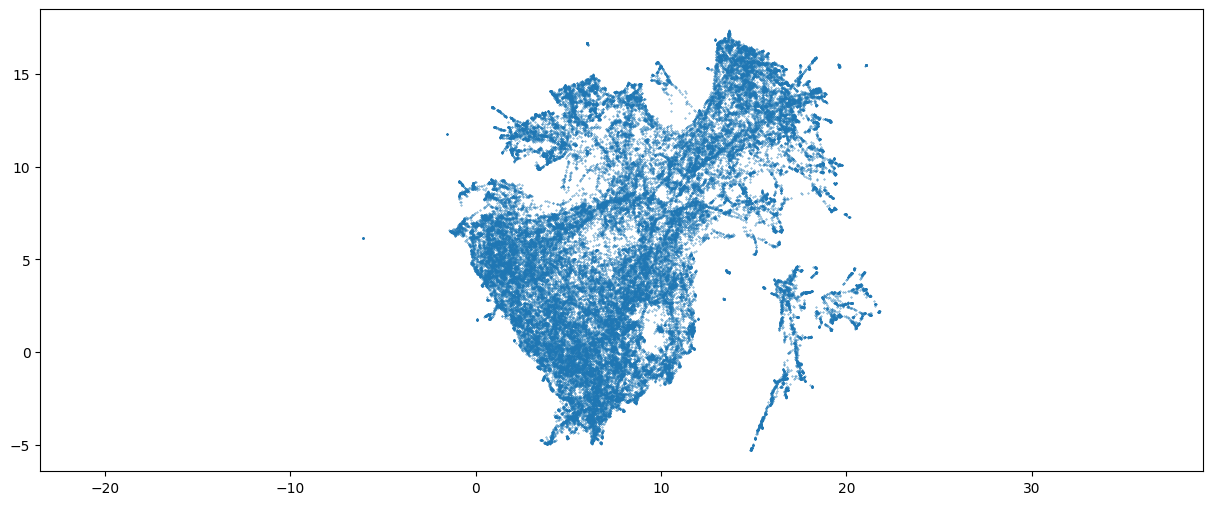

In [150]:
plt.scatter(
    standard_embedding[:, 0],
    standard_embedding[:, 1],
    s=0.1)
plt.gca().set_aspect('equal', 'datalim')

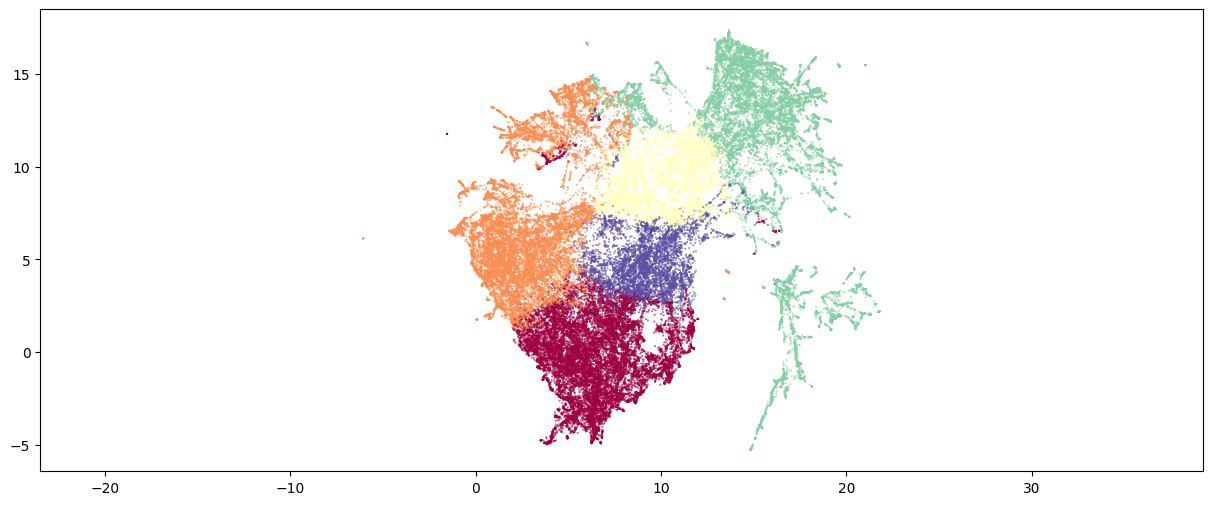

In [151]:
plt.scatter(
    standard_embedding[:, 0],
    standard_embedding[:, 1],
    s=0.1,
    c=kmeans_label_zscore,
    cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')



# Looking at the clusters

In [152]:
raise ValueError()

ValueError: 

In [ ]:
"/scratch/back_up/reward_competition_extention/in_progress/rce3/sleap_id_correction/to_be_checked"

In [164]:
exploded_columns

,frame_index,tone_frame,session_dir,tone_start_frame,reward_start,reward_dispensed,tone_stop_frame,condition,competition_closeness,notes,...,video_name,current_subject,thorax_velocity_sum,thorax_velocity_diff,subject_thorax_to_agent_thorax,thorax_to_reward_port_sum,thorax_to_reward_port_diff,to_reward_port_angle_sum,to_reward_port_angle_diff,current_frame
0,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",0,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,2.893205,1.282187,20.567259,24.34494,5.527499,4.270728,1.297317,1287
1,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",1,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,3.250033,1.173289,19.867992,23.547163,4.728733,3.90539,1.677733,1288
2,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",2,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,3.632047,1.107251,20.566919,24.287676,5.488344,4.230106,1.958936,1289
3,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",3,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,3.998641,1.052262,20.29561,24.120689,6.209442,4.071607,1.694412,1290
4,"[1287, 1288, 1289, 1290, 1291, 1292, 1293, 129...",4,20240317_151922_long_comp_subj_3-1_and_3-3,1286,1366,1386,1486,3.3,Subj 2 then Subj 1,NaN,...,20240317_151922_long_comp_subj_3-1_and_3-3.1,3.1,4.331422,1.041183,19.554232,23.498714,6.831412,3.889274,1.417664,1291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63258,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",194,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,20240321_114851_long_comp_subj_5-2_and_5-3.1,5.2,2.782604,0.563186,6.339526,10.671217,0.688222,1.563077,0.814962,55398
63259,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",195,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,20240321_114851_long_comp_subj_5-2_and_5-3.1,5.2,2.595525,0.290204,7.005285,10.441821,0.964035,1.70163,0.712266,55399
63260,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",196,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,20240321_114851_long_comp_subj_5-2_and_5-3.1,5.2,2.402601,0.050896,6.056912,10.733814,0.691269,1.593057,0.332952,55400
63261,"[55204, 55205, 55206, 55207, 55208, 55209, 552...",197,20240321_114851_long_comp_subj_5-2_and_5-3,55203,55283,55303,55402,tie,Close Call,NaN,...,20240321_114851_long_comp_subj_5-2_and_5-3.1,5.2,2.24506,0.143452,6.325613,10.757318,1.120854,1.736525,0.072992,55401


In [173]:

def extract_frames_and_make_gif(video_path, frame_numbers, output_folder, gif_name="output.gif", fps=10):
    """
    Extracts frames from a video at specific frame numbers and creates a GIF from those frames.

    Parameters:
        video_path (str): Path to the video file.
        frame_numbers (list): List of frame numbers to extract.
        output_folder (str): Directory to save the frames and GIF.
        gif_name (str): Filename for the GIF.
        fps (int): Frames per second for the GIF.
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Prepare to extract frames
    frames = []
    frame_ids = set(frame_numbers)  # Convert list to set for faster lookup
    current_frame = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if current_frame in frame_ids:
            frame_path = os.path.join(output_folder, f"frame_{current_frame}.png")
            cv2.imwrite(frame_path, frame)
            frames.append(frame_path)
            print(f"Extracted frame {current_frame}")
        
        current_frame += 1
    
    # Close video file
    cap.release()

    # Create GIF
    if frames:
        with imageio.get_writer(os.path.join(output_folder, gif_name), mode='I', fps=fps) as writer:
            for filename in frames:
                image = imageio.imread(filename)
                writer.append_data(image)
        print(f"GIF created at {os.path.join(output_folder, gif_name)}")
    else:
        print("No frames extracted, GIF not created.")



In [ ]:
# Example usage
video_path = 'path_to_your_video.mp4'
frame_numbers = [100, 200, 300, 400]  # Example frame numbers
output_folder = 'extracted_frames'



In [176]:
cluster_df["current_frame"].to_list()

[1393,
 1394,
 1395,
 1396,
 1397,
 1398,
 1399,
 1400,
 1401,
 1402,
 1403,
 1404,
 1405,
 1406,
 1407,
 1408,
 1409,
 1410,
 1411,
 1412,
 1413,
 1414,
 1415,
 1416,
 1417,
 1418,
 1419,
 1420,
 1421,
 1422,
 1423,
 1424,
 1425,
 1426,
 1427,
 1428,
 1429,
 1430,
 1431,
 1432,
 1433,
 1434,
 1435,
 1452,
 1453,
 1454,
 1455,
 1456,
 1457,
 1458,
 1459,
 1460,
 1461,
 1462,
 1463,
 1464,
 1465,
 1466,
 1467,
 1468,
 1469,
 1470,
 1471,
 1472,
 1473,
 1474,
 1475,
 1476,
 1477,
 1478,
 1479,
 1480,
 1481,
 1482,
 1483,
 1484,
 1485,
 1486,
 3283,
 3284,
 3285,
 3286,
 3287,
 3288,
 3289,
 3290,
 3291,
 3292,
 3293,
 3294,
 3295,
 3296,
 3297,
 3298,
 3299,
 3300,
 3301,
 3302,
 3303,
 3304,
 3305,
 3306,
 3307,
 3308,
 3309,
 3310,
 3311,
 3312,
 3313,
 3314,
 3315,
 3316,
 3317,
 3318,
 3319,
 3320,
 3321,
 3322,
 3323,
 3324,
 3325,
 3326,
 3327,
 3328,
 3329,
 3330,
 3331,
 3332,
 3333,
 3334,
 3335,
 3336,
 3337,
 3338,
 3339,
 3340,
 3341,
 3342,
 3343,
 3344,
 3345,
 3346,
 3347,

In [181]:
from pathlib import Path
import imageio

In [184]:
for cluster in exploded_columns["kmeans_cluster"].unique():
    cluster_df = exploded_columns[exploded_columns["kmeans_cluster"] == cluster]
    for vid in cluster_df["video_name"].unique():
        video_df = cluster_df[cluster_df["video_name"] == vid]
        video_name = "{}.fixed.mp4".format(vid)
        video_path = os.path.join("/scratch/back_up/reward_competition_extention/in_progress/rce3/sleap_id_correction/to_be_checked", video_name)
        
        frame_numbers = video_df["current_frame"].to_list()
        Path("./proc/{}/{}".format(cluster, video_name)).mkdir(parents=True, exist_ok=True)
        extract_frames_and_make_gif(video_path, frame_numbers, "./proc/{}/{}".format(cluster, video_name), gif_name="cluster_{}_{}.gif".format(cluster, video_name), fps=25)

Extracted frame 1287
Extracted frame 1288
Extracted frame 1289
Extracted frame 1290
Extracted frame 1291
Extracted frame 1292
Extracted frame 1293
Extracted frame 1294
Extracted frame 1295
Extracted frame 1296
Extracted frame 1297
Extracted frame 1298
Extracted frame 1316
Extracted frame 1317
Extracted frame 1318
Extracted frame 1319
Extracted frame 1320
Extracted frame 1321
Extracted frame 1322
Extracted frame 1323
Extracted frame 1324
Extracted frame 1325
Extracted frame 1326
Extracted frame 1327
Extracted frame 1328
Extracted frame 1329
Extracted frame 1330
Extracted frame 1331
Extracted frame 1332
Extracted frame 1333
Extracted frame 1334
Extracted frame 1335
Extracted frame 1336
Extracted frame 1337
Extracted frame 1338
Extracted frame 1339
Extracted frame 1340
Extracted frame 1341
Extracted frame 1342
Extracted frame 1343
Extracted frame 1344
Extracted frame 1345
Extracted frame 1346
Extracted frame 1347
Extracted frame 1348
Extracted frame 1349
Extracted frame 1350
Extracted fra

/tmp/ipykernel_233931/4181792461.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF created at ./proc/0/20240317_151922_long_comp_subj_3-1_and_3-3.1.fixed.mp4/cluster_0_20240317_151922_long_comp_subj_3-1_and_3-3.1.fixed.mp4.gif
Extracted frame 1366
Extracted frame 1367
Extracted frame 1368
Extracted frame 1369
Extracted frame 1370
Extracted frame 1371
Extracted frame 1372
Extracted frame 1373
Extracted frame 1374
Extracted frame 1375
Extracted frame 1376
Extracted frame 1377
Extracted frame 1378
Extracted frame 1379
Extracted frame 1380
Extracted frame 1381
Extracted frame 1382
Extracted frame 1383
Extracted frame 1385
Extracted frame 1386
Extracted frame 1387
Extracted frame 1388
Extracted frame 1389
Extracted frame 1403
Extracted frame 1404
Extracted frame 1405
Extracted frame 1406
Extracted frame 1407
Extracted frame 1408
Extracted frame 1411
Extracted frame 1412
Extracted frame 1413
Extracted frame 1414
Extracted frame 1415
Extracted frame 1416
Extracted frame 1418
Extracted frame 1419
Extracted frame 1420
Extracted frame 1422
Extracted frame 1423
Extracted fr

Traceback (most recent call last):
  File "/tmp/ipykernel_233931/4181792461.py", line 47, in extract_frames_and_make_gif
    image = imageio.imread(filename)
  File "/home/pc_lab/miniforge3/envs/mountainsort_0_5_6/lib/python3.9/site-packages/imageio/__init__.py", line 97, in imread
    return imread_v2(uri, format=format, **kwargs)
  File "/home/pc_lab/miniforge3/envs/mountainsort_0_5_6/lib/python3.9/site-packages/imageio/v2.py", line 360, in imread
    result = file.read(index=0, **kwargs)
  File "/home/pc_lab/miniforge3/envs/mountainsort_0_5_6/lib/python3.9/site-packages/imageio/plugins/pillow.py", line 252, in read
    image = self._apply_transforms(
  File "/home/pc_lab/miniforge3/envs/mountainsort_0_5_6/lib/python3.9/site-packages/imageio/plugins/pillow.py", line 333, in _apply_transforms
    image = np.asarray(image)
  File "/home/pc_lab/miniforge3/envs/mountainsort_0_5_6/lib/python3.9/site-packages/PIL/Image.py", line 696, in __array_interface__
    % (
  File "/home/pc_lab/mini

In [ ]:
raise ValueError()

#TODO: Add frame number for the video
- Do this by making a list of frame numbers and exploding that

In [ ]:
cluster_df

In [ ]:
exploded_columns

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np; np.random.seed(42)

# Generate data x, y for scatter and an array of images.
x = np.arange(20)
y = np.random.rand(len(x))
arr = np.empty((len(x),10,10))
for i in range(len(x)):
    f = np.random.rand(5,5)
    arr[i, 0:5,0:5] = f
    arr[i, 5:,0:5] =np.flipud(f)
    arr[i, 5:,5:] =np.fliplr(np.flipud(f))
    arr[i, 0:5:,5:] = np.fliplr(f)

# create figure and plot scatter
fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot(x,y, ls="", marker="o")

# create the annotations box
im = OffsetImage(arr[0,:,:], zoom=5)
xybox=(50., 50.)
ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
        boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
# add it to the axes and make it invisible
ax.add_artist(ab)
ab.set_visible(False)

def hover(event):
    # if the mouse is over the scatter points
    if line.contains(event)[0]:
        # find out the index within the array from the event
        ind, = line.contains(event)[1]["ind"]
        # get the figure size
        w,h = fig.get_size_inches()*fig.dpi
        ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
        hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
        # if event occurs in the top or right quadrant of the figure,
        # change the annotation box position relative to mouse.
        ab.xybox = (xybox[0]*ws, xybox[1]*hs)
        # make annotation box visible
        ab.set_visible(True)
        # place it at the position of the hovered scatter point
        ab.xy =(x[ind], y[ind])
        # set the image corresponding to that point
        im.set_data(arr[ind,:,:])
    else:
        #if the mouse is not over a scatter point
        ab.set_visible(False)
    fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)           
plt.show()

In [ ]:
raise ValueError()

In [ ]:

# Importing all necessary libraries 
import cv2 
import os 
  
# Read the video from specified path 
cam = cv2.VideoCapture("C:\\Users\\Admin\\PycharmProjects\\project_1\\openCV.mp4") 
  
try: 
      
    # creating a folder named data 
    if not os.path.exists('data'): 
        os.makedirs('data') 
  
# if not created then raise error 
except OSError: 
    print ('Error: Creating directory of data') 
  
# frame 
currentframe = 0
  
while(True): 
      
    # reading from frame 
    ret,frame = cam.read() 
  
    if ret: 
        # if video is still left continue creating images 
        name = './data/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name) 
  
        # writing the extracted images 
        cv2.imwrite(name, frame) 
  
        # increasing counter so that it will 
        # show how many frames are created 
        currentframe += 1
    else: 
        break
  
# Release all space and windows once done 
cam.release() 
cv2.destroyAllWindows() 


In [ ]:
def encode_strings_to_numbers(strings):
    """
    Encodes an array of strings to an array of unique integers.

    Parameters:
        strings (numpy.array): Numpy array of string values.

    Returns:
        numpy.array: An array of integers where each integer represents a unique string.
    """
    # Create a dictionary to map strings to numbers
    unique_strings = np.unique(strings)
    string_to_number = {string: idx for idx, string in enumerate(unique_strings)}

    # Map the original strings to their corresponding numbers
    number_array = np.vectorize(string_to_number.get)(strings)

    return number_array

In [ ]:
encode_strings_to_numbers(exploded_columns["competition_closeness"].values)

In [ ]:
plt.scatter(
    standard_embedding[:, 0],
    standard_embedding[:, 1],
    s=0.1,
    c=encode_strings_to_numbers(exploded_columns["competition_closeness"].values),
    cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

In [ ]:
standard_embedding

In [ ]:
raise ValueError

# Plotting

In [ ]:
raise ValueError()

In [ ]:
### Figure plotting for Paper
plotting code for paper ready plots
fig, ax = plt.subplots(figsize=(8, 8))
scatter = plt.scatter(subsample_cluster_df['embedding_zscore_x_standard'],
                             subsample_cluster_df['embedding_zscore_y_standard'],
                             c=subsample_cluster_df['raw_kmeans_labels_zscore'],
                             s=0.1,
                             cmap='Spectral')
plt.title('Behavior Clusters', fontsize = 24)
legend = plt.legend(*scatter.legend_elements(),
                    bbox_to_anchor=(.94, 1),
                    frameon = False,
                    fontsize = 22,
                    markerscale = 2,
                    ncol = 1,
                    handletextpad = -0.2,
                    columnspacing = 0.2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xticks([])
plt.yticks([])

In [ ]:
raise ValueError()

In [ ]:
is_first = True
recording_labels = []
frame_indice_labels = []

for file, recording in info.items():
    #creating arrays for recording name, strain, frame indice, 
    # and trial indice (0 for iti, 0-10 for tone) that are as long as there are frames 
    recording_labels += [file] * recording.locations.shape[0]
    file_row = tone_times_df[tone_times_df['File Name'] == file]

    frame_indice_labels = np.concatenate([frame_indice_labels,np.arange(0, recording.locations.shape[0])], axis = 0)
    temp_trial_indices = np.zeros(recording.locations.shape[0])
    #loading in normalization_factor since not all the videos are the same size / resolution
    distance_normalization_factor = box_setup[file]['distance_normalization_factor']
    #loading in reward_point (x,y)
    reward_port = box_setup[file]['reward_port']
    #creating the tone snippets from 0-10 for the frames during the tone
    for trial in recording.tones:
        try:
            temp_trial_indices[trial:trial+trial_length] = np.linspace(0,10,300)
        except ValueError:
            pass
    if is_first:
        trial_indices = temp_trial_indices
    else: 
        trial_indices = np.concatenate([trial_indices, temp_trial_indices])

    if is_first:
        features = np.stack([f1, f2, f3, f6, f7, f8, f9])
    else:
        temp_features =  np.stack([f1, f2, f3, f6, f7, f8, f9])
        features = np.concatenate([features,temp_features], axis = 1)
    is_first = False
recording_labels = np.array(recording_labels)
strain_labels = np.array(strain_labels)
zscored_features = []
# z score each feature 
for i in range(features.shape[0]):
    mean = np.mean(features[i])
    std_dev = np.std(features[i])
    normalized = (features[i]-mean)/std_dev
    zscored_features.append(normalized)
# stack zscored features onto the feature calculations 
features = np.concatenate([features, np.stack(zscored_features)], axis = 0)
# name features 
feature_names = ['thorax distances', 'mouse velocity sum',
                'mouse velocity diff', 
                #'orientation b/w mice sum',
                #'orientation b/w mice diff', 
                'orientation to port sum',
                'orientation to port diff',
                'distance to port sum',
                'distance to port diff']
#name z score features feature name + _zscore
for name in range(len(feature_names)):
    zscore_name = feature_names[name]+'_zscore'
    feature_names.append(zscore_name)
#name the non-feature columns
new_columns = ['Strain',
               'Recording',
               'frame indice',
               'trial_indice',
               'tube_test_elo',
               'urine_marking_elo',
               'home_cage_observation_elo',
               'reward_comp_elo']
# add both lists to create a master list of all column names 
column_names = feature_names + new_columns
# appen them all into an array of features as columns and frames as rows
data = np.column_stack([features.T, 
                        recording_labels[:, None],
                        frame_indice_labels[:, None],
                        trial_indices[:,None],
# turn array into a Dataframe
df = pd.DataFrame(data, columns = column_names)
reduced_frames = len(df) 
#and subsample for every third frame (otherwise my computer crashes)
every_third_index = np.arange(0, reduced_frames, 3)
subsample_df = df.iloc[every_third_index]


In [ ]:
is_first = True
recording_labels = []
frame_indice_labels = []
strain_labels = []
tube_test_elo_labels = []
urine_marking_elo_labels = []
home_cage_observation_elo_labels = []
reward_comp_elo_labels = []
#trial length = 30 fps * 10 second tone
trial_length = 10*30
for file, recording in info.items():
    #creating arrays for recording name, strain, frame indice, 
    # and trial indice (0 for iti, 0-10 for tone) that are as long as there are frames 
    recording_labels += [file] * recording.locations.shape[0]
    strain_labels += [recording.strain] * recording.locations.shape[0]
    file_row = tone_times_df[tone_times_df['File Name'] == file]
    # grab elo score information
    if not file_row.empty:
        tube_test_elo_diff = file_row['tube_test_RD'].values[0]
        urine_marking_elo_diff = file_row['urine_marking_RD'].values[0]
        home_cage_elo_diff = file_row['home_cage_observation_RD'].values[0]
        reward_comp_elo_diff = file_row['reward_comp_RD'].values[0]
    else:
        tube_test_elo_diff = 0
        urine_marking_elo_diff = 0
        home_cage_elo_diff = 0
        reward_comp_elo_diff = 0
    #create arrays of length num_frames    
    tube_test_elo_labels += [tube_test_elo_diff] * recording.locations.shape[0]
    urine_marking_elo_labels += [urine_marking_elo_diff] * recording.locations.shape[0]
    home_cage_observation_elo_labels += [home_cage_elo_diff] * recording.locations.shape[0]
    reward_comp_elo_labels += [reward_comp_elo_diff] * recording.locations.shape[0]
    #turn all lists into np. arrays for concatenating and other functions
    tube_test_elo_array = np.array(tube_test_elo_labels)
    urine_marking_elo_array = np.array(urine_marking_elo_labels)
    home_cage_observation_elo_array = np.array(home_cage_observation_elo_labels)
    reward_comp_elo_array = np.array(reward_comp_elo_labels)
    frame_indice_labels = np.concatenate([frame_indice_labels,np.arange(0, recording.locations.shape[0])], axis = 0)
    temp_trial_indices = np.zeros(recording.locations.shape[0])
    #loading in normalization_factor since not all the videos are the same size / resolution
    distance_normalization_factor = box_setup[file]['distance_normalization_factor']
    #loading in reward_point (x,y)
    reward_port = box_setup[file]['reward_port']
    #creating the tone snippets from 0-10 for the frames during the tone
    for trial in recording.tones:
        try:
            temp_trial_indices[trial:trial+trial_length] = np.linspace(0,10,300)
        except ValueError:
            pass
    if is_first:
        trial_indices = temp_trial_indices
    else: 
        trial_indices = np.concatenate([trial_indices, temp_trial_indices])
    # features 1 - 2 distance between thoraxes and noses
    f1 = recording.distances_between_mice('thorax', distance_normalization_factor) # distances between mice works 
    #features 3-4: velocities of each mouse
    velocities = recording.node_velocity('thorax', normalization_factor = distance_normalization_factor)
    f2 = velocities[0] + velocities[1]# this one is from sleap so assuming this works
    f3 = np.abs(velocities[0] - velocities[1])
    #feature 5: angle of orientation between mice, 2pi is facing each other
    # 0 radians is not facing each other (or parallel)
    #orientations = recording.orientation()
    #f4 = orientations[0] + orientations [1]# this works
    #f5 = np.abs(orientations[0] - orientations [1])
    #feature 6-7: angle from nose to forehead to reward port
    angle_to_port = recording.point_angles('nose', 'thorax', reward_port)
    distance_to_port = recording.distances_to_point('nose', reward_port, distance_normalization_factor)
    f6 = angle_to_port[0] + angle_to_port[1]# this works with thorax
    f7 = np.abs(angle_to_port[0] - angle_to_port[1])
    #feature 8-9: distance to reward point for each mosue
    f8 = distance_to_port[0] + distance_to_port[1] # this works
    f9 = np.abs(distance_to_port[0] - distance_to_port[1])
    #add calculated features into a multidimensional array 
    # n columns for each feature, rows are calculations per frame
    if is_first:
        features = np.stack([f1, f2, f3, f6, f7, f8, f9])
    else:
        temp_features =  np.stack([f1, f2, f3, f6, f7, f8, f9])
        features = np.concatenate([features,temp_features], axis = 1)
    is_first = False
recording_labels = np.array(recording_labels)
strain_labels = np.array(strain_labels)
zscored_features = []
# z score each feature 
for i in range(features.shape[0]):
    mean = np.mean(features[i])
    std_dev = np.std(features[i])
    normalized = (features[i]-mean)/std_dev
    zscored_features.append(normalized)
# stack zscored features onto the feature calculations 
features = np.concatenate([features, np.stack(zscored_features)], axis = 0)
# name features 
feature_names = ['thorax distances', 'mouse velocity sum',
                'mouse velocity diff', 
                #'orientation b/w mice sum',
                #'orientation b/w mice diff', 
                'orientation to port sum',
                'orientation to port diff',
                'distance to port sum',
                'distance to port diff']
#name z score features feature name + _zscore
for name in range(len(feature_names)):
    zscore_name = feature_names[name]+'_zscore'
    feature_names.append(zscore_name)
#name the non-feature columns
new_columns = ['Strain',
               'Recording',
               'frame indice',
               'trial_indice',
               'tube_test_elo',
               'urine_marking_elo',
               'home_cage_observation_elo',
               'reward_comp_elo']
# add both lists to create a master list of all column names 
column_names = feature_names + new_columns
# appen them all into an array of features as columns and frames as rows
data = np.column_stack([features.T, 
                        strain_labels[:, None],
                        recording_labels[:, None],
                        frame_indice_labels[:, None],
                        trial_indices[:,None],
                        tube_test_elo_array[:, None],
                        urine_marking_elo_array[:, None],
                        home_cage_observation_elo_array[:, None],
                        reward_comp_elo_array[:,None]])
# turn array into a Dataframe
df = pd.DataFrame(data, columns = column_names)
reduced_frames = len(df) 
#and subsample for every third frame (otherwise my computer crashes)
every_third_index = np.arange(0, reduced_frames, 3)
subsample_df = df.iloc[every_third_index]


## Putting together LFP and video start/stop

In [ ]:
START_STOP_FRAME_DF["video_name"].unique()[:5]

In [ ]:
LFP_SPECTRAL_DF["video_name"].unique()[:5]

In [ ]:
LFP_SPECTRAL_DF["current_subject"].unique()

In [ ]:
START_STOP_FRAME_DF["current_subject"].unique()

In [ ]:
LFP_AND_SLEAP_DF = pd.merge(LFP_SPECTRAL_DF, START_STOP_FRAME_DF, on=["video_name", "current_subject"], how="inner")

In [ ]:
LFP_AND_SLEAP_DF["video_timestamps"].apply(lambda x: x.shape).head()

In [ ]:
LFP_AND_SLEAP_DF.head()

- Checking if any of the velocities contain Nans

In [ ]:
LFP_AND_SLEAP_DF[LFP_AND_SLEAP_DF["subject_thorax_velocity"].apply(lambda x: np.isnan(x).any())]

## Exporting

In [ ]:
LFP_AND_SLEAP_DF.columns

In [ ]:
FULL_LFP_TRACES_PKL

In [ ]:
LFP_AND_SLEAP_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [ ]:
LFP_AND_SLEAP_DF.head()

In [ ]:
for col in LFP_AND_SLEAP_DF.columns:
    print(col)

In [ ]:
raise ValueError()